# Import data and packages

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns
import statsmodels.api as sm
import math
import pyranges as pr
from sklearn.neighbors import NearestNeighbors
from intervaltree import Interval, IntervalTree
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from lineage_colors import lineage_colors
!pip install intervaltree

ATAC = pd.read_csv("data/1.ATAC-Seq data.CSV", sep=";")
# ATAC_Bcells in der Form importieren?
# ATAC_T_Bcells = pd.read_csv("data/ATAC_T_Bcells.csv", sep=";") -> Falsch

# Info about the data

In [100]:
ATAC.head()

,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,ImmGenATAC1219.peak_1,chr1,3020786,0.00,0.56,NaN,NaN,NaN,0.41,0.71,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,ImmGenATAC1219.peak_2,chr1,3087226,0.00,0.50,NaN,NaN,NaN,0.41,23377.00,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,ImmGenATAC1219.peak_3,chr1,3120109,0.07,45879.00,1.0,NaN,NaN,13181.00,0.10,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,ImmGenATAC1219.peak_4,chr1,3121485,0.15,45691.00,1.0,NaN,NaN,0.41,0.10,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,ImmGenATAC1219.peak_5,chr1,3372787,0.03,11324.00,NaN,NaN,NaN,0.41,0.10,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [101]:
ATAC.shape

(512595, 98)

In [102]:
ATAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512595 entries, 0 to 512594
Data columns (total 98 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   ImmGenATAC1219.peakID            512595 non-null  object 
 1   chrom                            512595 non-null  object 
 2   Summit                           512595 non-null  int64  
 3   mm10.60way.phastCons_scores      512595 non-null  float64
 4   _-log10_bestPvalue               512595 non-null  float64
 5   Included.in.systematic.analysis  334879 non-null  float64
 6   TSS                              14292 non-null   object 
 7   genes.within.100Kb               427710 non-null  object 
 8   LTHSC.34-.BM                     512595 non-null  float64
 9   LTHSC.34+.BM                     512595 non-null  float64
 10  STHSC.150-.BM                    512595 non-null  float64
 11  MPP4.135+.BM                     512595 non-null  float64
 12  pr

In [103]:
ATAC.describe()

,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
count,5.125950e+05,512595.000000,512595.00,334879.0,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,...,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000,512595.000000
mean,7.596866e+07,0.164662,inf,1.0,6095.046919,12936.332385,13396.369554,14257.896763,18034.640712,17227.101166,...,19704.822925,14624.972269,19226.011170,16158.995852,14094.576211,18267.934653,17140.037676,17792.495176,22193.477680,15764.502827
std,4.450542e+07,0.203403,NaN,0.0,9788.773579,14163.202535,16375.735345,16906.870910,18783.480143,18493.944435,...,20004.913558,16857.827083,18360.437997,17876.007879,16726.326963,18369.989966,18401.952190,18063.846271,19084.434031,17767.205876
min,1.430000e+02,0.000000,0.00,1.0,0.410000,0.100000,0.110000,0.110000,0.110000,0.100000,...,0.100000,0.100000,0.110000,0.110000,0.110000,0.110000,0.100000,0.110000,0.110000,0.110000
25%,3.802562e+07,0.030000,27.55,1.0,0.410000,0.710000,0.110000,0.110000,0.470000,0.630000,...,0.770000,0.540000,0.660000,0.530000,0.520000,0.560000,0.720000,0.570000,0.640000,0.530000
50%,7.364690e+07,0.080000,23408.00,1.0,0.410000,73.770000,0.900000,27.810000,16011.000000,12420.000000,...,15462.000000,11475.000000,17319.000000,13516.000000,61.080000,17168.000000,13516.000000,15766.000000,22282.000000,13150.000000
75%,1.091549e+08,0.220000,44197.00,1.0,13181.000000,23377.000000,31048.000000,21217.000000,41365.000000,34335.000000,...,44197.000000,28856.000000,41640.000000,30468.000000,27242.000000,35065.000000,33239.000000,33604.000000,44927.000000,31413.000000
max,1.953715e+08,1.000000,inf,1.0,46017.000000,46296.000000,46296.000000,46508.000000,47453.000000,47453.000000,...,47453.000000,47423.000000,47453.000000,47453.000000,47453.000000,47453.000000,47392.000000,47178.000000,47300.000000,47453.000000


# Data Clean-up

In [104]:
#coloums with numerical datas 
float_cols = ATAC.select_dtypes(include=['float64']).columns
print(float_cols)
ATAC_num = ATAC.select_dtypes(include=['float64'])
ATAC_num.head()

Index(['mm10.60way.phastCons_scores', '_-log10_bestPvalue',
       'Included.in.systematic.analysis', 'LTHSC.34-.BM', 'LTHSC.34+.BM',
       'STHSC.150-.BM', 'MPP4.135+.BM', 'proB.CLP.BM', 'proB.FrA.BM',
       'proB.FrBC.BM', 'preB.FrD.BM', 'B.FrE.BM', 'B1b.PC', 'B.T1.Sp',
       'B.T2.Sp', 'B.T3.Sp', 'B.Sp', 'B.Fem.Sp', 'B.MZ.Sp', 'B.Fo.Sp',
       'B.mem.Sp', 'B.GC.CB.Sp', 'B.GC.CC.Sp', 'B.PB.Sp', 'B.PC.Sp', 'B.PC.BM',
       'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th',
       'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp',
       'T.4.Nve.Fem.Sp', 'T.8.Nve.Sp', 'T.4.Sp.aCD3+CD40.18hr',
       'Treg.4.FP3+.Nrplo.Co', 'Treg.4.25hi.Sp', 'T8.TN.P14.Sp',
       'T8.IEL.LCMV.d7.SI', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp',
       'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp',
       'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d',
       'Tgd.g2+d17.24a+.Th', 'Tgd.g2+d17.LN', 'Tgd.g2+d1.24a+.Th',
       'Tgd.g2+d1.LN', 'Tgd.g1.1+d1.24a+.

,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,0.00,0.56,NaN,0.41,0.71,0.90,0.11,34335.00,0.10,0.11,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,0.00,0.50,NaN,0.41,23377.00,0.90,0.83,0.47,0.34,0.82,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,0.07,45879.00,1.0,13181.00,0.10,0.90,0.11,0.47,0.10,0.50,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,0.15,45691.00,1.0,0.41,0.10,0.11,0.11,0.79,0.40,0.50,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,0.03,11324.00,NaN,0.41,0.10,0.11,0.11,0.47,0.34,28491.00,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [105]:
#remove col accoring to Included.in.systematic.analysis 
ATAC_included_values = ATAC_num.drop(columns=['Included.in.systematic.analysis'])
ATAC_included_values = ATAC_included_values.replace([np.inf, -np.inf], np.nan).dropna()
ATAC_included_values.head()

,mm10.60way.phastCons_scores,_-log10_bestPvalue,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,preB.FrD.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,0.00,0.56,0.41,0.71,0.90,0.11,34335.00,0.10,0.11,25204.00,...,0.10,0.10,43525.00,13516.00,0.52,46388.00,0.10,0.57,46447.0,14977.00
1,0.00,0.50,0.41,23377.00,0.90,0.83,0.47,0.34,0.82,0.13,...,45839.00,0.10,14977.00,0.47,0.11,0.92,0.98,42401.00,12451.0,0.94
2,0.07,45879.00,13181.00,0.10,0.90,0.11,0.47,0.10,0.50,42736.00,...,0.87,0.54,26330.00,0.95,0.11,63.38,33817.00,12055.00,45748.0,0.11
3,0.15,45691.00,0.41,0.10,0.11,0.11,0.79,0.40,0.50,44958.00,...,0.44,30317.00,0.66,0.11,0.92,45790.00,0.98,46753.00,45748.0,0.11
4,0.03,11324.00,0.41,0.10,0.11,0.11,0.47,0.34,28491.00,42736.00,...,0.44,0.10,0.66,28856.00,0.51,0.92,0.75,12055.00,22282.0,45781.00


In [106]:
# standardizing the values 
scaler = StandardScaler()
ATAC_scaled = scaler.fit_transform(ATAC_included_values)
ATAC_scaled = pd.DataFrame(ATAC_scaled, columns=ATAC_included_values.columns)
ATAC_scaled.head()

,mm10.60way.phastCons_scores,_-log10_bestPvalue,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,preB.FrD.BM,...,DC.4+.Sp,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th
0,-0.809539,-1.322500,-0.622619,-0.913335,-0.818014,-0.843321,0.867794,-0.931503,-0.956155,0.241998,...,-0.985004,-0.867550,1.323434,-0.147860,-0.842635,1.530753,-0.931429,-0.984957,1.270846,-0.044332
1,-0.809539,-1.322503,-0.622619,0.737160,-0.818014,-0.843278,-0.960118,-0.931490,-0.956118,-1.104052,...,1.306379,-0.867550,-0.231432,-0.903931,-0.842659,-0.994405,-0.931381,1.362299,-0.510506,-0.887236
2,-0.465393,1.249028,0.723878,-0.913378,-0.818014,-0.843321,-0.960118,-0.931503,-0.956135,1.178320,...,-0.984966,-0.867524,0.386909,-0.903904,-0.842659,-0.991005,0.906252,-0.317633,1.234219,-0.887283
3,-0.072084,1.238491,-0.622619,-0.913378,-0.818063,-0.843321,-0.960101,-0.931487,-0.956135,1.296989,...,-0.984987,0.930837,-1.047119,-0.903951,-0.842611,1.498200,-0.931381,1.603222,1.234219,-0.887283
4,-0.662048,-0.687811,-0.622619,-0.913378,-0.818063,-0.843321,-0.960118,-0.931490,0.543993,1.178320,...,-0.984987,-0.867550,-1.047119,0.710273,-0.842635,-0.994405,-0.931393,-0.317633,0.004627,1.689424


In [107]:
# check if standardization worked
print("mean (should be ~0):", np.mean(ATAC_scaled, axis=0))
print("sd (should be ~1):", np.std(ATAC_scaled, axis=0))

mean (should be ~0): mm10.60way.phastCons_scores   -1.188789e-16
_-log10_bestPvalue            -1.480996e-16
LTHSC.34-.BM                  -3.077323e-16
LTHSC.34+.BM                   6.387524e-17
STHSC.150-.BM                  7.474290e-17
                                   ...     
FRC.SLN                        3.832514e-16
IAP.SLN                       -1.583574e-16
BEC.SLN                        3.459909e-17
LEC.SLN                       -1.517037e-16
Ep.MEChi.Th                    2.708044e-16
Length: 92, dtype: float64
sd (should be ~1): mm10.60way.phastCons_scores    1.0
_-log10_bestPvalue             1.0
LTHSC.34-.BM                   1.0
LTHSC.34+.BM                   1.0
STHSC.150-.BM                  1.0
                              ... 
FRC.SLN                        1.0
IAP.SLN                        1.0
BEC.SLN                        1.0
LEC.SLN                        1.0
Ep.MEChi.Th                    1.0
Length: 92, dtype: float64


## ATAC transposed dataset - B-cell specific

In [108]:
# of scaled values
ATAC_scaled_Peaks_Bcells = ATAC_scaled.iloc[:, 2:31]
ATAC_T_scaled_Bcells = ATAC_scaled_Peaks_Bcells.T
ATAC_T_scaled_Bcells.head()

,0,1,2,3,4,5,6,7,8,9,...,512580,512581,512582,512583,512584,512585,512586,512587,512588,512589
LTHSC.34-.BM,-0.622619,-0.622619,0.723878,-0.622619,-0.622619,0.723878,-0.622619,0.723878,0.767295,-0.621946,...,0.767295,-0.622619,-0.622619,-0.622619,0.723878,0.767295,-0.622619,-0.622619,-0.622619,-0.622619
LTHSC.34+.BM,-0.913335,0.737160,-0.913378,-0.913378,-0.913378,0.737160,-0.913378,-0.913335,-0.913378,-0.913378,...,-0.912441,0.558881,2.355367,0.156853,1.138976,1.138976,0.156853,-0.913335,0.737160,-0.913335
STHSC.150-.BM,-0.818014,-0.818014,-0.818014,-0.818063,-0.818063,1.077905,-0.818063,-0.818014,-0.818014,-0.818063,...,0.451491,0.722929,0.345481,1.077905,-0.818014,0.345481,0.345481,-0.818063,-0.818063,-0.818014
MPP4.135+.BM,-0.843321,-0.843278,-0.843321,-0.843321,-0.843321,0.409772,-0.843321,-0.843321,-0.843321,-0.843321,...,-0.025909,0.411606,1.642998,0.218844,1.642998,0.411606,1.862672,-0.843278,-0.843278,0.218844
proB.CLP.BM,0.867794,-0.960118,-0.960118,-0.960101,-0.960118,1.488393,-0.960137,0.148332,-0.960120,-0.960118,...,1.482909,0.172555,0.772231,0.524194,1.473752,1.397622,-0.057541,-0.960095,-0.960095,0.694450


In [109]:
# included in systematic analysis - makes more sense because we only look at B-cells anyway
ATAC_included_values_Bcells = ATAC_included_values.iloc[:, 2:25]
ATAC_T_included_values_Bcells = ATAC_included_values_Bcells.T
ATAC_T_included_values_Bcells.head()

,0,1,2,3,4,5,6,7,8,9,...,512585,512586,512587,512588,512589,512590,512591,512592,512593,512594
LTHSC.34-.BM,0.41,0.41,13181.00,0.41,0.41,13181.0,0.41,13181.00,13606.00,7.00,...,13606.00,0.41,0.41,0.41,13181.0,13606.0,0.41,0.41,0.41,0.41
LTHSC.34+.BM,0.71,23377.00,0.10,0.10,0.10,23377.0,0.10,0.71,0.10,0.10,...,13.37,20852.00,46296.00,15158.00,29068.0,29068.0,15158.00,0.71,23377.00,0.71
STHSC.150-.BM,0.90,0.90,0.90,0.11,0.11,31048.0,0.11,0.90,0.90,0.11,...,20790.00,25235.00,19054.00,31048.00,0.9,19054.0,19054.00,0.11,0.11,0.90
MPP4.135+.BM,0.11,0.83,0.11,0.11,0.11,21186.0,0.11,0.11,0.11,0.11,...,13820.00,21217.00,42036.00,17958.00,42036.0,21217.0,45750.00,0.83,0.83,17958.00
proB.CLP.BM,34335.00,0.47,0.47,0.79,0.47,45992.0,0.11,20821.00,0.42,0.47,...,45889.00,21276.00,32540.00,27881.00,45717.0,44287.0,16954.00,0.90,0.90,31079.00


### Clustering the peaks

In [ ]:
#reduce ATAC_scaled to cell-type only columns
non_signal_cols = ['mm10.60way.phastCons_scores', '_-log10_bestPvalue']
ATAC_scaled_ct = ATAC_scaled.drop(columns=non_signal_cols)
ATAC_scaled_ct.to_csv("data/ATAC_scaled.ct.csv", index=False) 
ATAC_scaled_ct.head()

KeyboardInterrupt: 

In [ ]:
K = range(1, 11)
a = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(ATAC_scaled_ct)
    a.append(kmeans.inertia_)

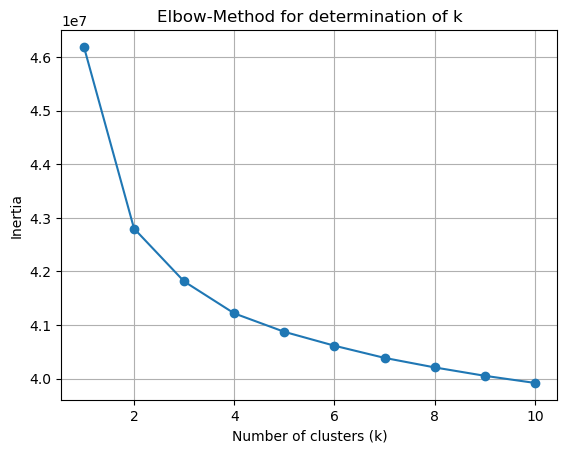

In [ ]:
#Elbow-Plot to choose optimal cluster number
plt.plot(K, a, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow-Method for determination of k')
plt.grid(True)
plt.show()

In [ ]:
#probably a knik at k=4, but we will also have a look at k=3 and k=5
#Reducing to 10 dimensions through PCA 
pca = PCA(n_components=10)
ATAC_pca10 = pca.fit_transform(ATAC_scaled_ct)

In [ ]:
#try clustering with k=(3,4,5) 
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3.fit(ATAC_scaled_ct)

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_4.fit(ATAC_scaled_ct)

kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_5.fit(ATAC_scaled_ct)

labels_3 = kmeans_3.labels_
labels_4 = kmeans_4.labels_
labels_5 = kmeans_5.labels_

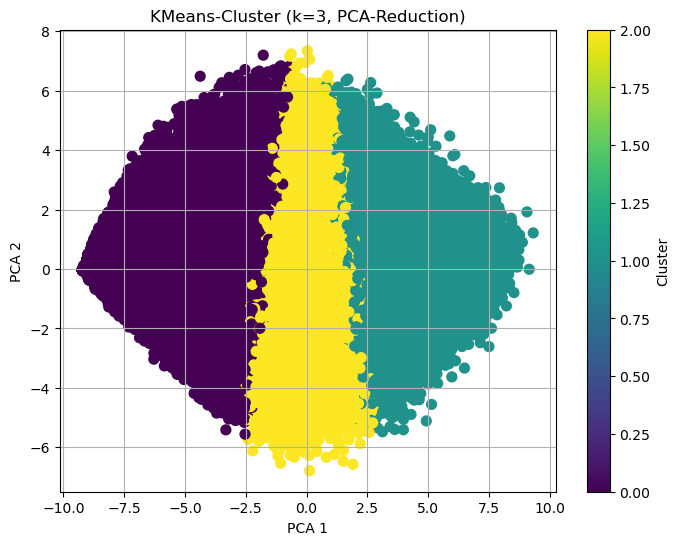

In [ ]:
#to visualize PCA und Cluster-Plot 
pca = PCA(n_components=2)
ATAC_pca = pca.fit_transform(ATAC_scaled_ct)

#for k=3
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_3, cmap='viridis', s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KMeans-Cluster (k=3, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

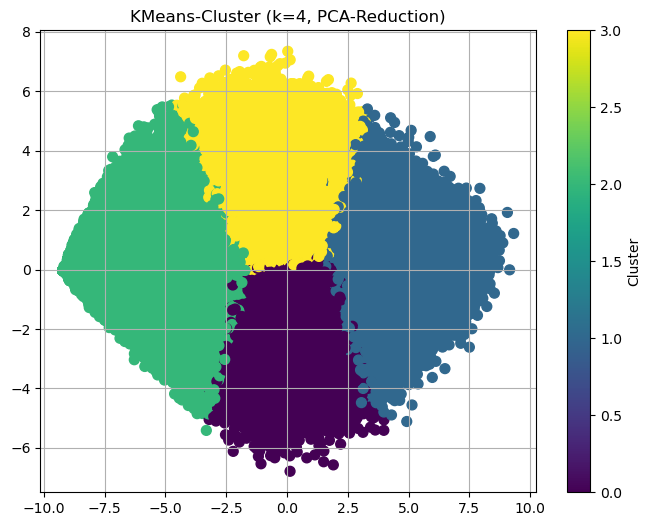

In [ ]:
#for k=4
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_4, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=4, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

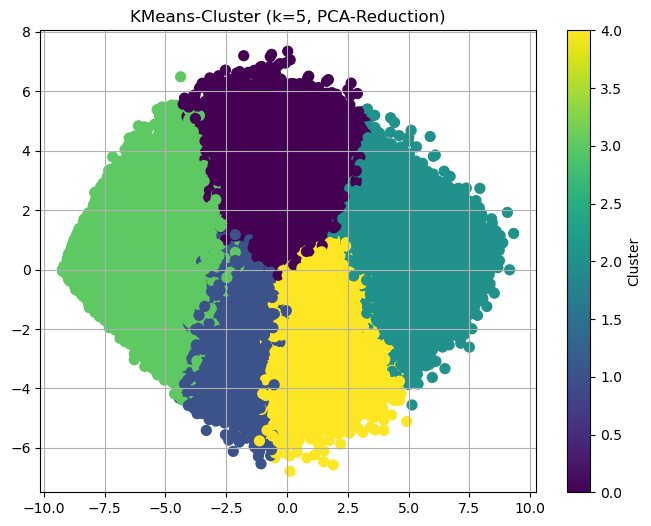

In [ ]:
#for k=5
plt.figure(figsize=(8,6))
plt.scatter(ATAC_pca[:, 0], ATAC_pca[:, 1], c=labels_5, cmap='viridis', s=50)
plt.title('KMeans-Cluster (k=5, PCA-Reduction)')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Since the Elbow-Plot showed an assumable knik at k=4 and the clusters look good as well, we will continue the analysis with k=4.

# Additional plots

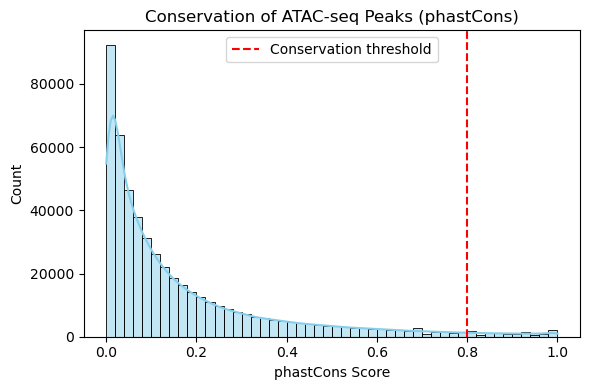

In [110]:
# PhastCons Conservation Score Distribution of ATAC-seq Peaks
phast_scores = ATAC["mm10.60way.phastCons_scores"].dropna()

plt.figure(figsize=(6, 4))
sns.histplot(phast_scores, bins=50, kde=True, color='skyblue')
plt.axvline(0.8, color='red', linestyle='--', label='Conservation threshold')
plt.xlabel('phastCons Score')
plt.title('Conservation of ATAC-seq Peaks (phastCons)')
plt.legend()
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


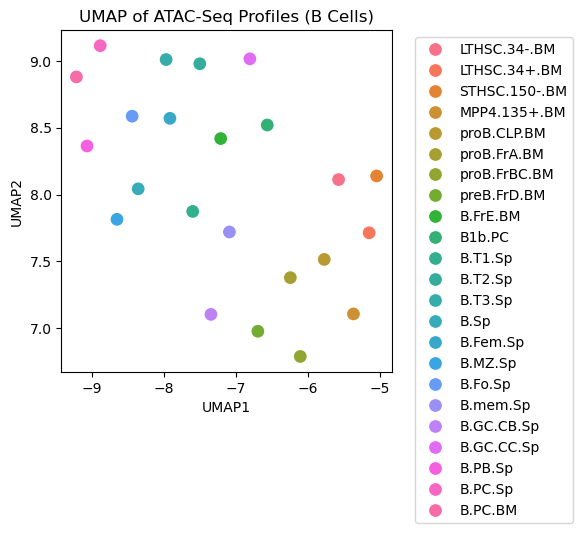

In [111]:
# Select the cell columns (columns 9 to 31; Python is zero-indexed, so columns 8 to 30)
cell_columns = ATAC.columns[8:31]

# Peak matrix: rows = peaks, columns = cells
signal = ATAC[cell_columns]

# Convert to numpy array
signal_values = signal.values

# Clean NaN and infinite values
signal_clean = np.nan_to_num(signal_values, nan=0.0, posinf=1e10, neginf=-1e10)

# Standardize the data
signal_scaled = StandardScaler().fit_transform(signal_clean)

# UMAP (transpose so cells are rows)
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(signal_scaled.T)

# Create a DataFrame with UMAP results and cell names
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df["Sample"] = cell_columns

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Sample", s=100)
plt.title("UMAP of ATAC-Seq Profiles (B Cells)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/3f/pxvhxt1x4477ds3p64jyb_6c0000gn/T/ipykernel_88848/1832368072.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


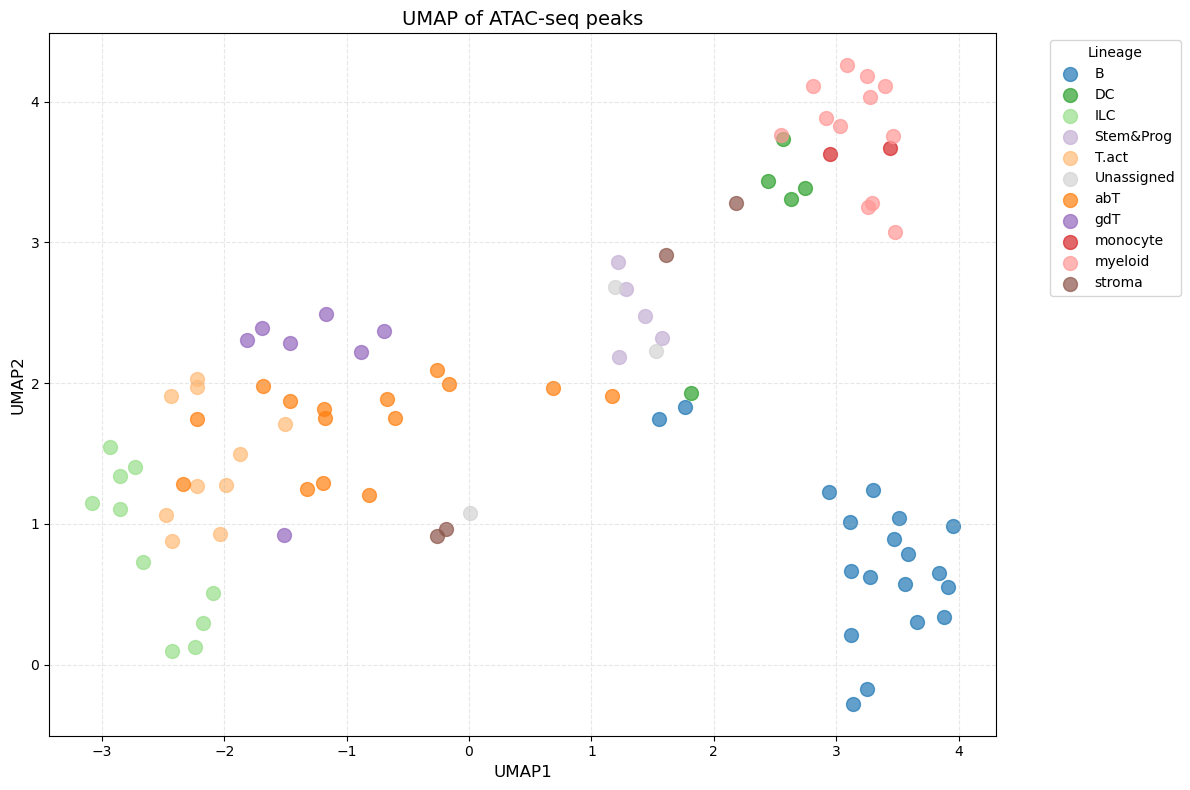

In [ ]:
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

ATAC_transposed = ATAC_scaled.T
ATAC_transposed.index.name = "CellType"

# lineage for each sample
qc = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
qc.columns = qc.columns.str.strip()
qc["CellType"] = qc["CellType"].str.strip()
qc["Lineage"] = qc["Lineage"].str.strip()
celltype_to_lineage = qc.drop_duplicates("CellType").set_index("CellType")["Lineage"]
df_meta = pd.DataFrame(index=ATAC_transposed.index)
df_meta["Lineage"] = df_meta.index.map(celltype_to_lineage).fillna("Unassigned")

# colors
df_meta["Color"] = df_meta["Lineage"].map(lineage_colors)

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embedding = reducer.fit_transform(ATAC_transposed)

df_meta["UMAP1"] = umap_embedding[:, 0]
df_meta["UMAP2"] = umap_embedding[:, 1]

# Plot
plt.figure(figsize=(12, 8))

for lineage, group in df_meta.groupby("Lineage"):
    plt.scatter(
        group["UMAP1"],
        group["UMAP2"],
        c=group["Color"].iloc[0],
        label=lineage,
        s=100,
        alpha=0.7
    )

plt.title('UMAP of ATAC-seq peaks', fontsize=14)
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Lineage")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("figures/UMAP_ATAC_peaks.png", dpi=300, bbox_inches="tight")
plt.show()

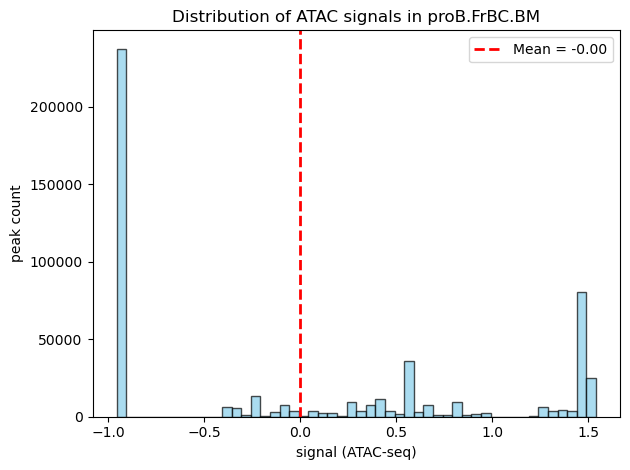

In [113]:
# select column – z. B. for examole cell type "proB.FrBC.BM"
values = ATAC_scaled["proB.FrBC.BM"].dropna()

# calculate mean
mean_val = values.mean()

# Histogram with mean line
plt.hist(values, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(mean_val, color="red", linestyle="dashed", linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.xlabel("signal (ATAC-seq)")
plt.ylabel("peak count")
plt.title("Distribution of ATAC signals in proB.FrBC.BM")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of average peak signals in B cells - Histogram

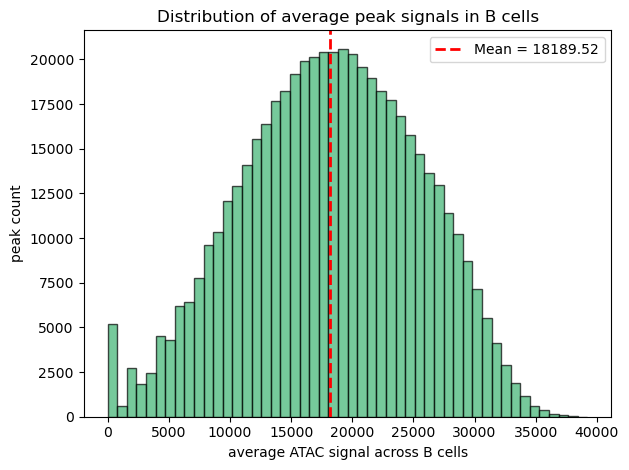

In [114]:
# matrix with ATAC-Seq peaks of B-cells
signal_columns = ATAC_included_values.columns[2:25] 

# mean across columns of B-cells (per row)
ATAC_included_values["peak_mean_signal"] = ATAC_included_values[signal_columns].mean(axis=1)

# Histogramm des Mittelwerts aller Peaks
plt.hist(ATAC_included_values["peak_mean_signal"].dropna(), bins=50, color="mediumseagreen", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_included_values["peak_mean_signal"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_included_values['peak_mean_signal'].mean():.2f}")
plt.xlabel("average ATAC signal across B cells")
plt.ylabel("peak count")
plt.title("Distribution of average peak signals in B cells")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of ATAC-Seq mean values per B-cell specific cell types - Histogram

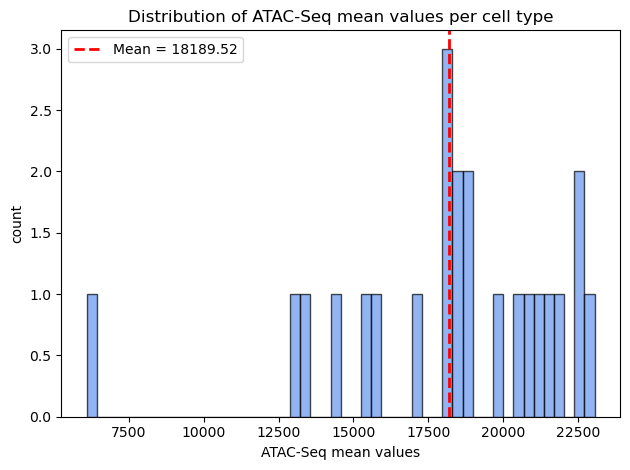

In [115]:

# copy of the B-cell specific transformed matrix
ATAC_T_included_values_Bcells_copy = ATAC_T_included_values_Bcells.copy()

# mean per row across all columns
ATAC_T_included_values_Bcells_copy["row_mean"] = ATAC_T_included_values_Bcells_copy.mean(axis=1)

# Histogramm plotten
plt.hist(ATAC_T_included_values_Bcells_copy["row_mean"].dropna(), bins=50, color="cornflowerblue", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_T_included_values_Bcells_copy["row_mean"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_T_included_values_Bcells_copy['row_mean'].mean():.2f}")
plt.xlabel("ATAC-Seq mean values")
plt.ylabel("count")
plt.title("Distribution of ATAC-Seq mean values per cell type")
plt.legend()
plt.tight_layout()
plt.show()

### Distribution of ATAC-Seq median values per B-cell specific cell types - Histogram

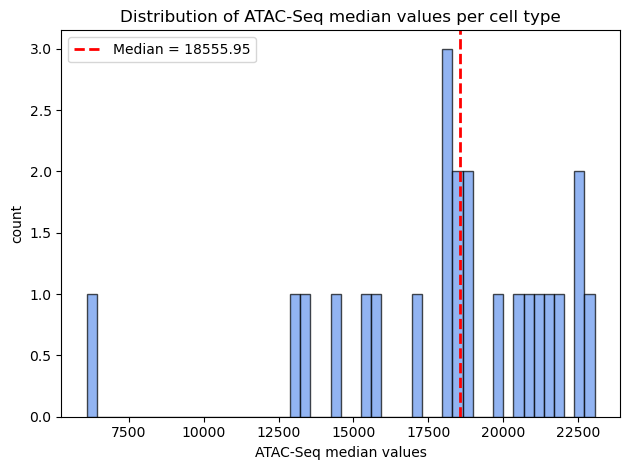

In [116]:

# copy of the B-cell specific transformed matrix
ATAC_T_included_values_Bcells_copy = ATAC_T_included_values_Bcells.copy()

# median per row across all columns
ATAC_T_included_values_Bcells_copy["row_mean"] = ATAC_T_included_values_Bcells_copy.mean(axis=1)

# Histogramm plotten
plt.hist(ATAC_T_included_values_Bcells_copy["row_mean"].dropna(), bins=50, color="cornflowerblue", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_T_included_values_Bcells_copy["row_mean"].median(), color="red", linestyle="dashed", linewidth=2, label=f"Median = {ATAC_T_included_values_Bcells_copy['row_mean'].median():.2f}")
plt.xlabel("ATAC-Seq median values")
plt.ylabel("count")
plt.title("Distribution of ATAC-Seq median values per cell type")
plt.legend()
plt.tight_layout()
plt.show()

### Significance vs. conservation - Scatter plot

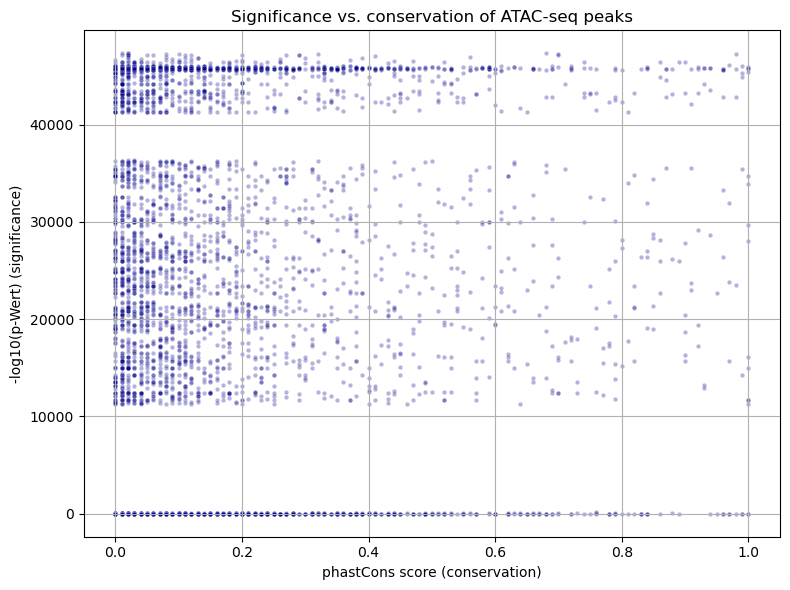

In [117]:
# selection of the two columns

ATAC_filtered = ATAC[["_-log10_bestPvalue", "mm10.60way.phastCons_scores"]].dropna()

# scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=ATAC_filtered.sample(n=5000, random_state=42),  # optional: nur 5000 Punkte für bessere Performance
    x="mm10.60way.phastCons_scores",
    y="_-log10_bestPvalue",
    alpha=0.3,
    s=10,
    color="darkblue"
)
plt.xlabel("phastCons score (conservation)")
plt.ylabel("-log10(p-Wert) (significance)")
plt.title("Significance vs. conservation of ATAC-seq peaks")
plt.grid(True)
plt.tight_layout()
plt.show()


# 1. Differences and similarities of the chromatin landscape between immune cells

## i. How variable is the chromatin signal within cells?

### a) Is the signal dependent on sequencing depth, number of input cells, QC metric?

For that we first calculated the mean signal for all peaks per cell type.
Afterwards we linked the QC data with the signal. A scatterplot shows the Signal vs.different aspects. Then we calculated the correlation and visualized it. 

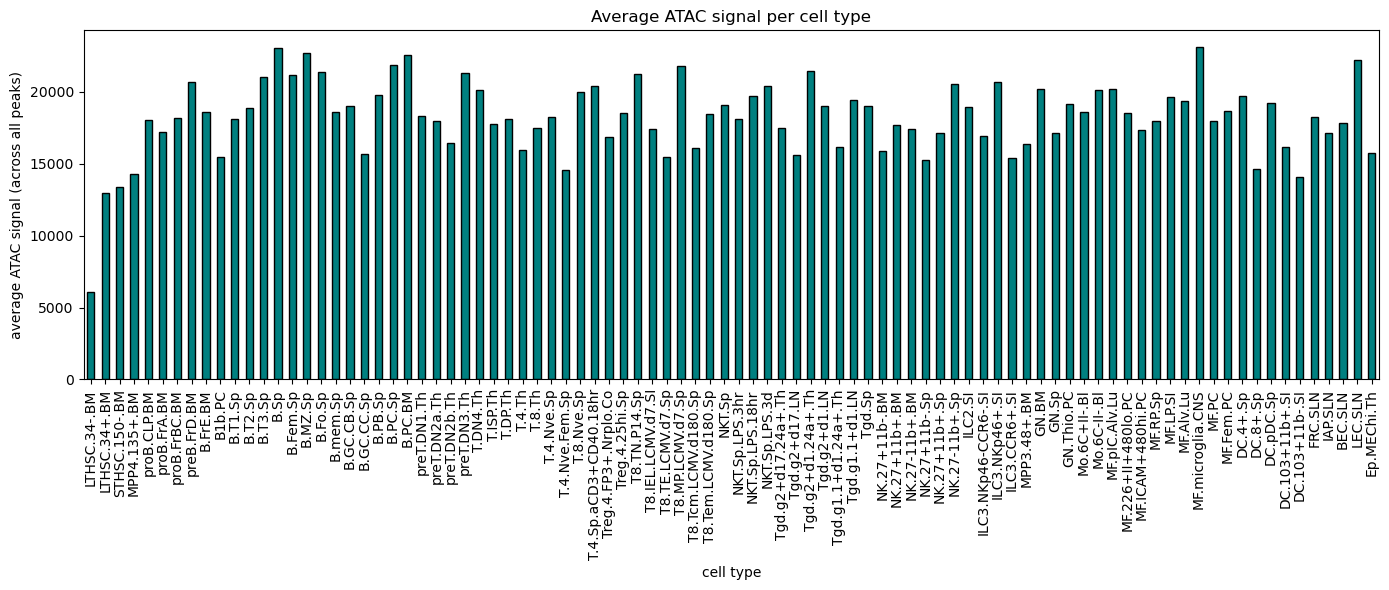

In [118]:
# matrix with all cell types and corresponding ATAC-seq peaks
celltype_columns = ATAC_scaled.columns[2:92] 

# mean per cell type (across all peaks)
celltype_means = ATAC[celltype_columns].mean()

# plot
plt.figure(figsize=(14, 6))
celltype_means.plot(kind="bar", color="teal", edgecolor="black")
plt.ylabel("average ATAC signal (across all peaks)")
plt.xlabel("cell type")
plt.title("Average ATAC signal per cell type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [119]:
# load the converted QC matric 
QC_conv_num = pd.read_csv("data/QC_converted_numerical.CSV")

#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

#group QC/ 
QC_mean = QC_conv_num.groupby("CellType").mean()

#link mean values with the QC data
ATAC_combined = pd.merge(ATAC_mean_df, QC_mean, on='CellType')
ATAC_combined = ATAC_combined.rename(columns={0: "ATAC_mean"})

ATAC_combined.head()


,CellType,ATAC_mean,InputCellNumber,PF.reads,%chrM.mapped,Paired.read.after.removing.PCR.duplication,%fragment.1Kb_TSS,Replicate.cor
0,LTHSC.34-.BM,6095.046919,677.0,22287984.0,4.580,2470102.0,10.600,NaN
1,LTHSC.34+.BM,12936.332385,2483.0,28588536.0,3.170,7675501.0,7.700,NaN
2,STHSC.150-.BM,13396.369554,3660.0,22170346.0,3.250,6060045.0,11.130,NaN
3,MPP4.135+.BM,14257.896763,10000.0,24003590.0,13.830,6128252.0,18.960,NaN
4,proB.CLP.BM,18034.640712,10000.0,21903414.0,9.035,6347376.5,15.605,0.868


In [120]:
print(ATAC_combined.columns)

Index(['CellType', 'ATAC_mean', 'InputCellNumber', 'PF.reads', '%chrM.mapped',
       'Paired.read.after.removing.PCR.duplication', '%fragment.1Kb_TSS',
       'Replicate.cor'],
      dtype='object')


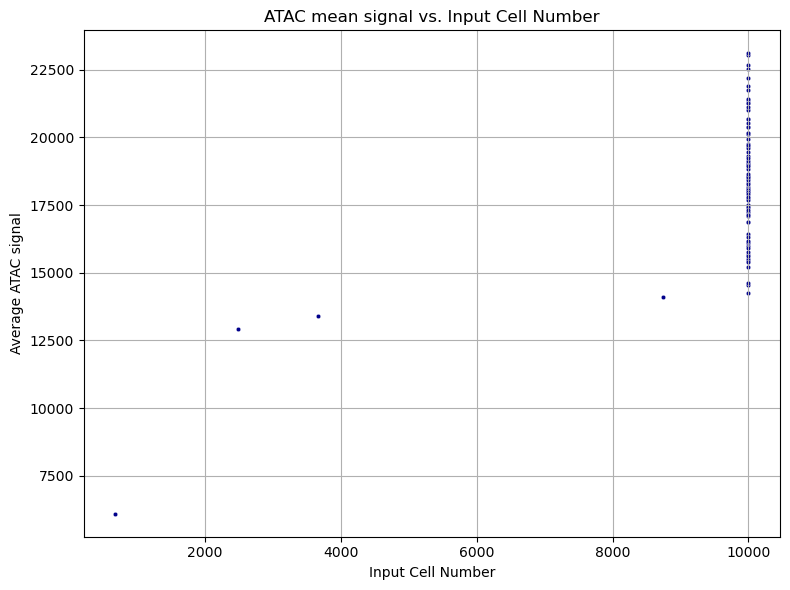

In [121]:
#scatterplot of ATAC-Signal vs. Input Cell number
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="InputCellNumber", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Input Cell Number")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Input Cell Number")
plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
# does input cell number really just contain 10.000?
ATAC_combined["InputCellNumber"].value_counts()

InputCellNumber
10000.0    85
677.0       1
2483.0      1
3660.0      1
8750.0      1
Name: count, dtype: int64

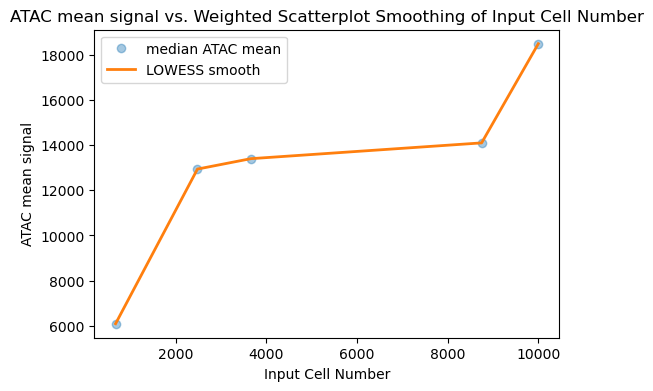

In [124]:
aggregated_data = ATAC_combined.groupby("InputCellNumber").ATAC_mean.agg(["median","count"])

lowess = sm.nonparametric.lowess
aggregated_data["sm"] = lowess(aggregated_data["median"], aggregated_data.index, frac=0.4)[:,1]

# Make sure your index is sorted
aggregated_data = aggregated_data.sort_index()

# Plot the raw medians and the LOWESS smooth
plt.figure(figsize=(6,4))
plt.plot(aggregated_data.index, aggregated_data["median"], "o", alpha=0.4, label="median ATAC mean")
plt.plot(aggregated_data.index, aggregated_data["sm"], "-", lw=2, label="LOWESS smooth")
plt.title("ATAC mean signal vs. Weighted Scatterplot Smoothing of Input Cell Number")
plt.xlabel("Input Cell Number")
plt.ylabel("ATAC mean signal")
plt.legend()
plt.show()

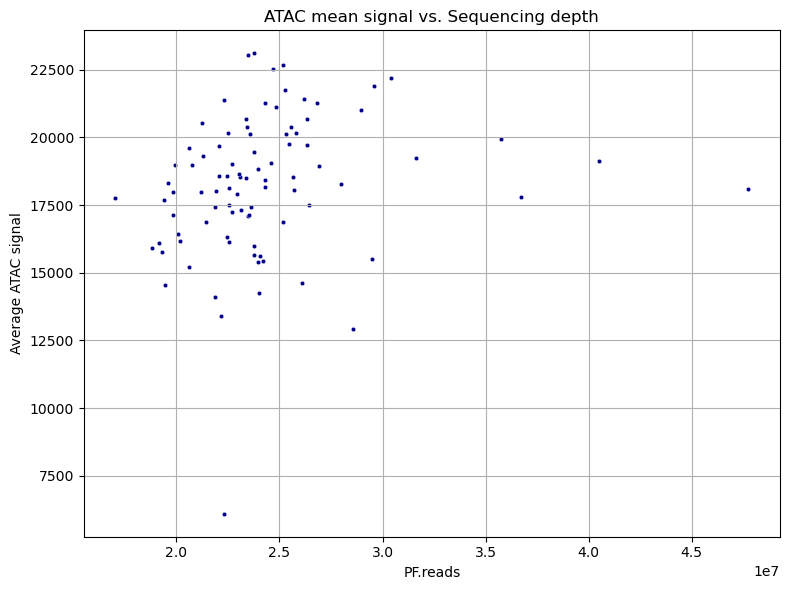

In [125]:
#scatterplot of ATAC-Signal vs. Sequencing depth
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="PF.reads", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("PF.reads")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Sequencing depth")
plt.grid(True)
plt.tight_layout()
plt.show()

#says how many reads there are -> more mean better information 
# do you only look at strongly open parts (low sequencing depth) or also at weakly open parts (high depth)

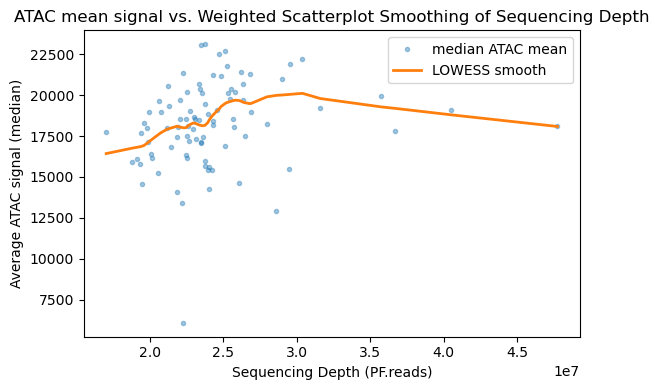

In [ ]:
aggregated_data_depth = ATAC_combined.groupby("PF.reads").ATAC_mean.agg(["median", "count"])

# 1) Extract x & y as simple NumPy arrays
x = aggregated_data_depth.index.values
y = aggregated_data_depth["median"].values

# 2) Run LOWESS — this returns an array of shape (m,2), where m ≤ len(x)
smoothed = lowess(y, x, frac=0.4)

# 3) Turn that into a Series whose index is the sorted x’s
sm_series = pd.Series(
    data=smoothed[:,1],
    index=smoothed[:,0]
)

# 4) Re‐index it onto your DataFrame’s full index (fills missing with NaN)
aggregated_data_depth["sm"] = sm_series.reindex(aggregated_data_depth.index)

plt.figure(figsize=(6,4))
plt.plot(aggregated_data_depth.index, aggregated_data_depth["median"], ".", alpha=0.4, label="median ATAC mean")    
plt.plot(aggregated_data_depth.index, aggregated_data_depth["sm"], "-", lw=2, label="LOWESS smooth")
plt.title("ATAC mean signal vs. Weighted Scatterplot Smoothing of Sequencing Depth")
plt.xlabel("Sequencing Depth (PF.reads)")
plt.ylabel("Average ATAC signal (median)")
plt.legend()
plt.tight_layout()
plt.show()

# there is an upward trend in for few reads, which plateaus at around 25,000,000 reads

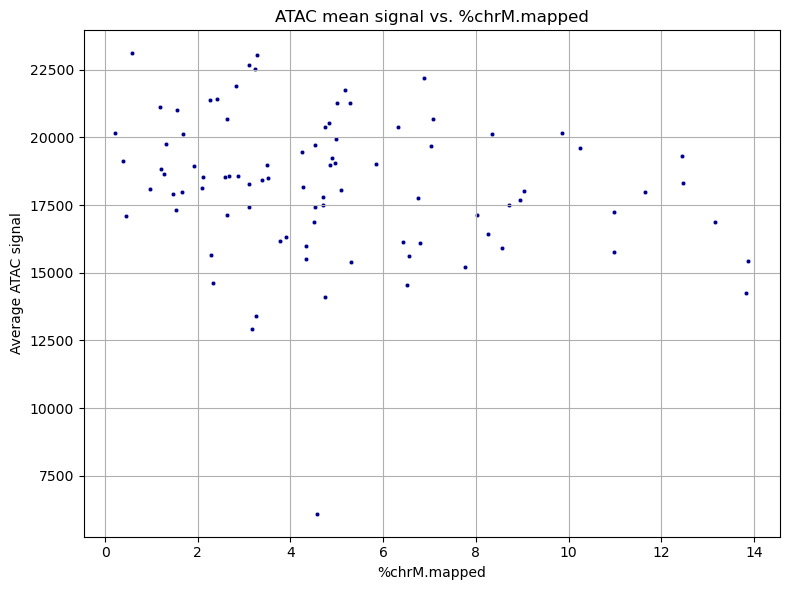

In [127]:
#scatterplot of ATAC-Signal vs. %chrM.mapped
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%chrM.mapped", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("%chrM.mapped")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %chrM.mapped")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are from mitochondria (not useful)

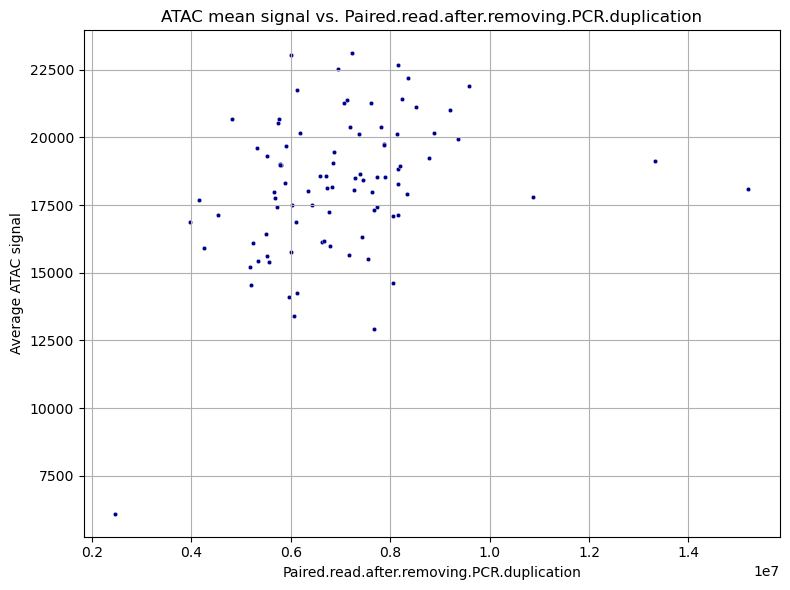

In [128]:
#scatterplot of ATAC-Signal vs. Paired.read.after.removing.PCR.duplication
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Paired.read.after.removing.PCR.duplication", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Paired.read.after.removing.PCR.duplication")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Paired.read.after.removing.PCR.duplication")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many unique reads after removing duplications 

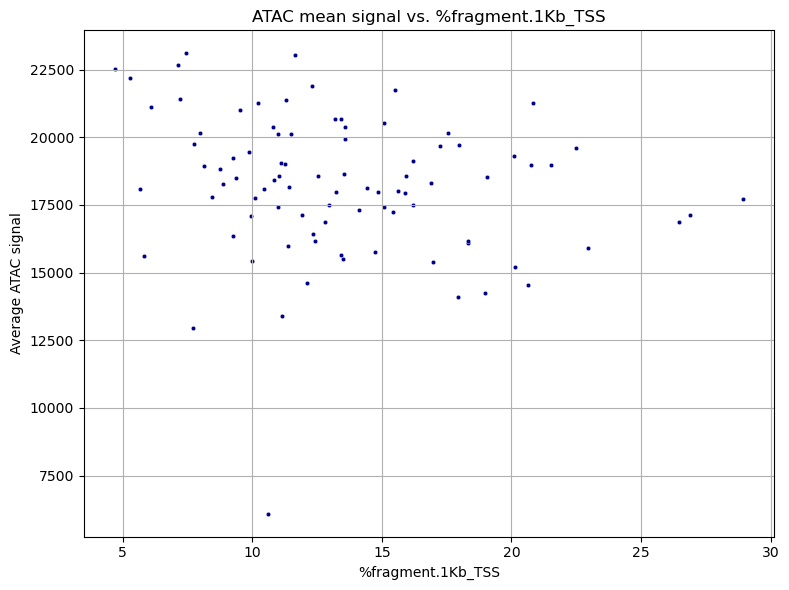

In [129]:
#scatterplot of ATAC-Signal vs. %fragment.1Kb_TSS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="%fragment.1Kb_TSS", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("%fragment.1Kb_TSS")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. %fragment.1Kb_TSS")
plt.grid(True)
plt.tight_layout()
plt.show()

#how many reads are close to start of gene

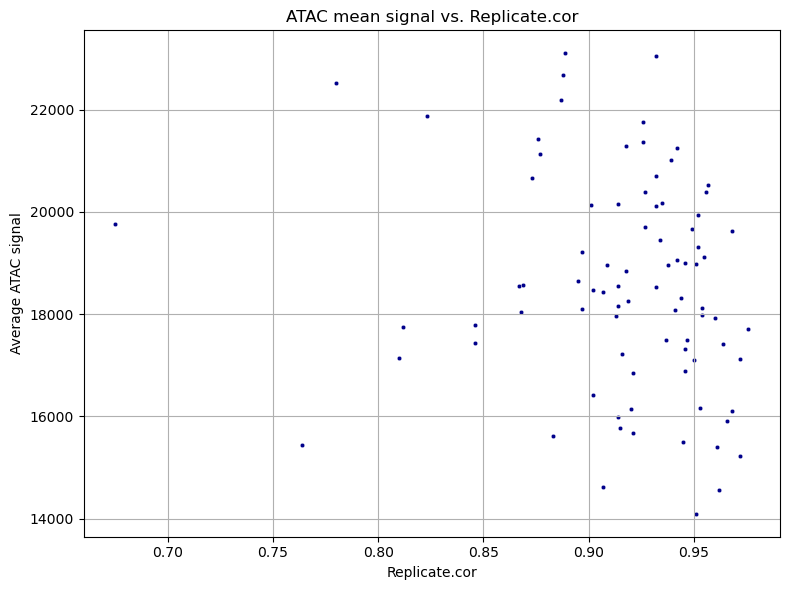

In [130]:
#scatterplot of ATAC-Signal vs. Replicate.cor
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ATAC_combined, x="Replicate.cor", y="ATAC_mean", alpha=1.0, s=10, color="darkblue")

plt.xlabel("Replicate.cor")
plt.ylabel("Average ATAC signal")
plt.title("ATAC mean signal vs. Replicate.cor")
plt.grid(True)
plt.tight_layout()
plt.show()

#how similar was the experiment when doing it multiple times 

In [131]:
ATAC_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 8 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CellType                                    89 non-null     object 
 1   ATAC_mean                                   89 non-null     float64
 2   InputCellNumber                             89 non-null     float64
 3   PF.reads                                    89 non-null     float64
 4   %chrM.mapped                                89 non-null     float64
 5   Paired.read.after.removing.PCR.duplication  89 non-null     float64
 6   %fragment.1Kb_TSS                           89 non-null     float64
 7   Replicate.cor                               84 non-null     float64
dtypes: float64(7), object(1)
memory usage: 5.7+ KB


In [132]:
#ATAC combined nur float 
ATAC_combined_num = ATAC_combined.iloc[:, 1:8]
ATAC_combined_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ATAC_mean                                   89 non-null     float64
 1   InputCellNumber                             89 non-null     float64
 2   PF.reads                                    89 non-null     float64
 3   %chrM.mapped                                89 non-null     float64
 4   Paired.read.after.removing.PCR.duplication  89 non-null     float64
 5   %fragment.1Kb_TSS                           89 non-null     float64
 6   Replicate.cor                               84 non-null     float64
dtypes: float64(7)
memory usage: 5.0 KB


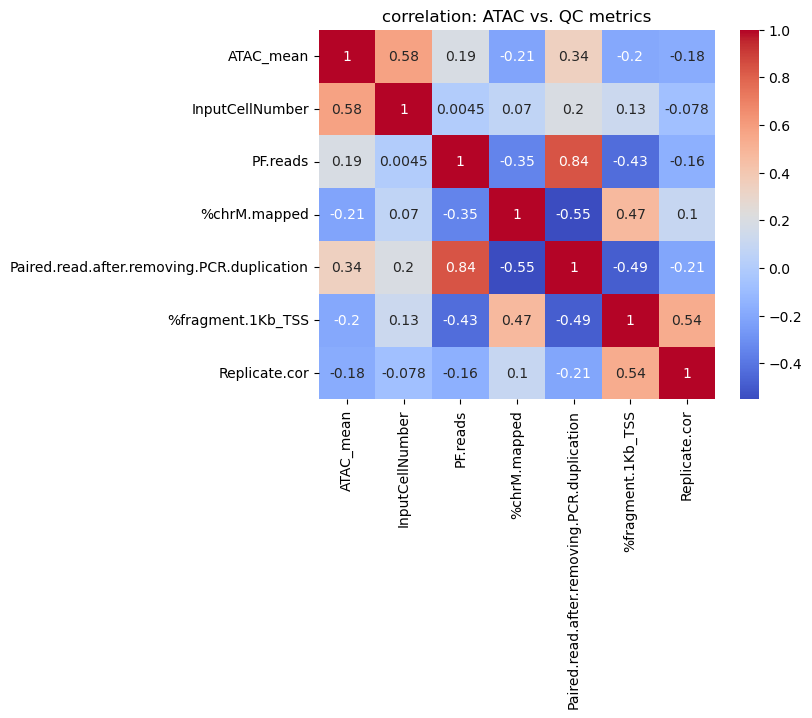

In [133]:
# correlation 
corr = ATAC_combined_num.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("correlation: ATAC vs. QC metrics")
plt.show()


ATAC signal is not depended on Replicate.cor, %fragment.1Kb_TSS, PF.read and %chrM.mapped. It is weakly depended on Paired.read.after.removing.PCR.duplication and strongly depended on InputCellNumbers

### Mean, Median and sd against QC across cell types

In [134]:
# preparing metrices 
celltype_columns = ATAC_scaled.columns[2:92]
celltype_means = ATAC_scaled[celltype_columns].mean()
celltype_medians = ATAC_scaled[celltype_columns].median()
celltype_sds = ATAC_scaled[celltype_columns].std()

#convert to dataframe
mean_df = celltype_means.reset_index()
mean_df.columns = ['CellType', 'ATAC_mean']

median_df = celltype_medians.reset_index()
median_df.columns = ['CellType', 'ATAC_median']

sd_df = celltype_sds.reset_index()
sd_df.columns = ['CellType', 'ATAC_sd']

#combine to one dataframe 
ATAC_stats_df = mean_df.merge(median_df, on='CellType').merge(sd_df, on='CellType')
ATAC_combined = pd.merge(ATAC_stats_df, QC_mean, on='CellType')
ATAC_combined['Replicate.cor'] = ATAC_combined['Replicate.cor'].fillna(0)

ATAC_combined.head()


,CellType,ATAC_mean,ATAC_median,ATAC_sd,InputCellNumber,PF.reads,%chrM.mapped,Paired.read.after.removing.PCR.duplication,%fragment.1Kb_TSS,Replicate.cor
0,LTHSC.34-.BM,-3.077323e-16,-0.622619,1.000001,677.0,22287984.0,4.580,2470102.0,10.600,0.000
1,LTHSC.34+.BM,6.387524e-17,-0.908176,1.000001,2483.0,28588536.0,3.170,7675501.0,7.700,0.000
2,STHSC.150-.BM,7.474290e-17,-0.818014,1.000001,3660.0,22170346.0,3.250,6060045.0,11.130,0.000
3,MPP4.135+.BM,-3.586606e-16,-0.841682,1.000001,10000.0,24003590.0,13.830,6128252.0,18.960,0.000
4,proB.CLP.BM,1.660645e-16,-0.107744,1.000001,10000.0,21903414.0,9.035,6347376.5,15.605,0.868


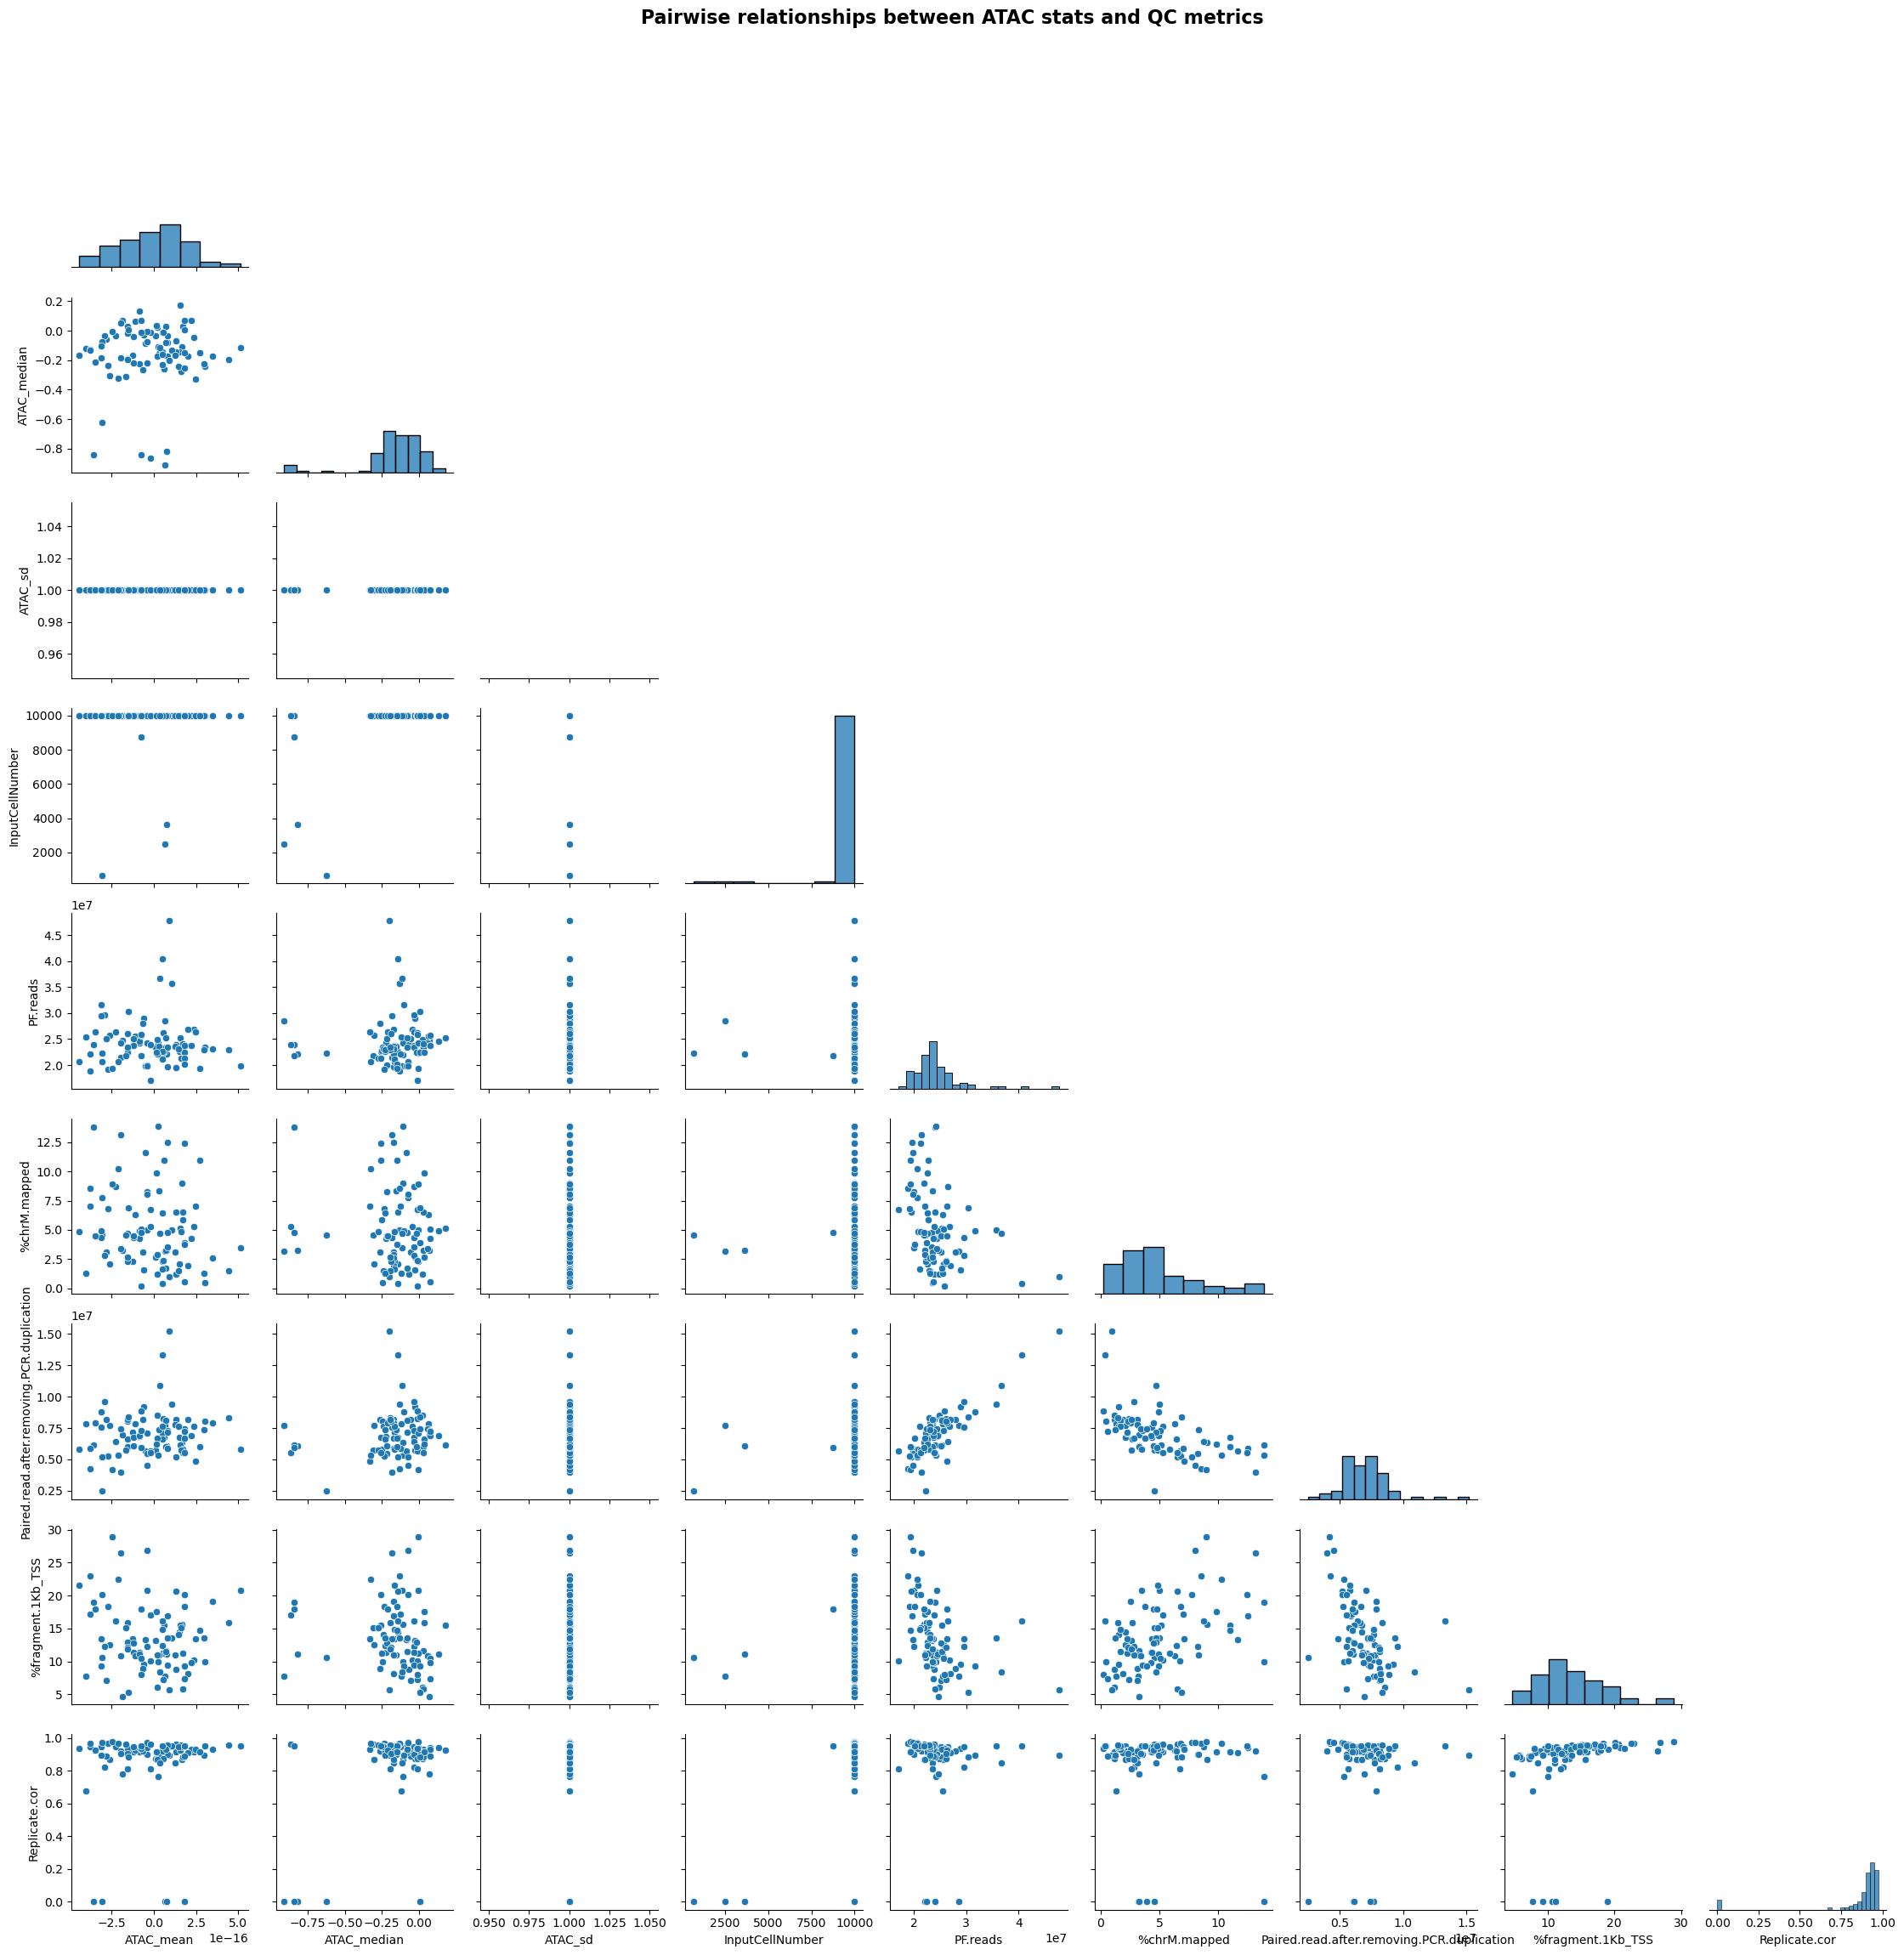

In [ ]:
# Ensure CellType is not used as numeric in plot
sns.pairplot(ATAC_combined.dropna(), corner=True)
plt.suptitle("Pairwise relationships between ATAC stats and QC metrics", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


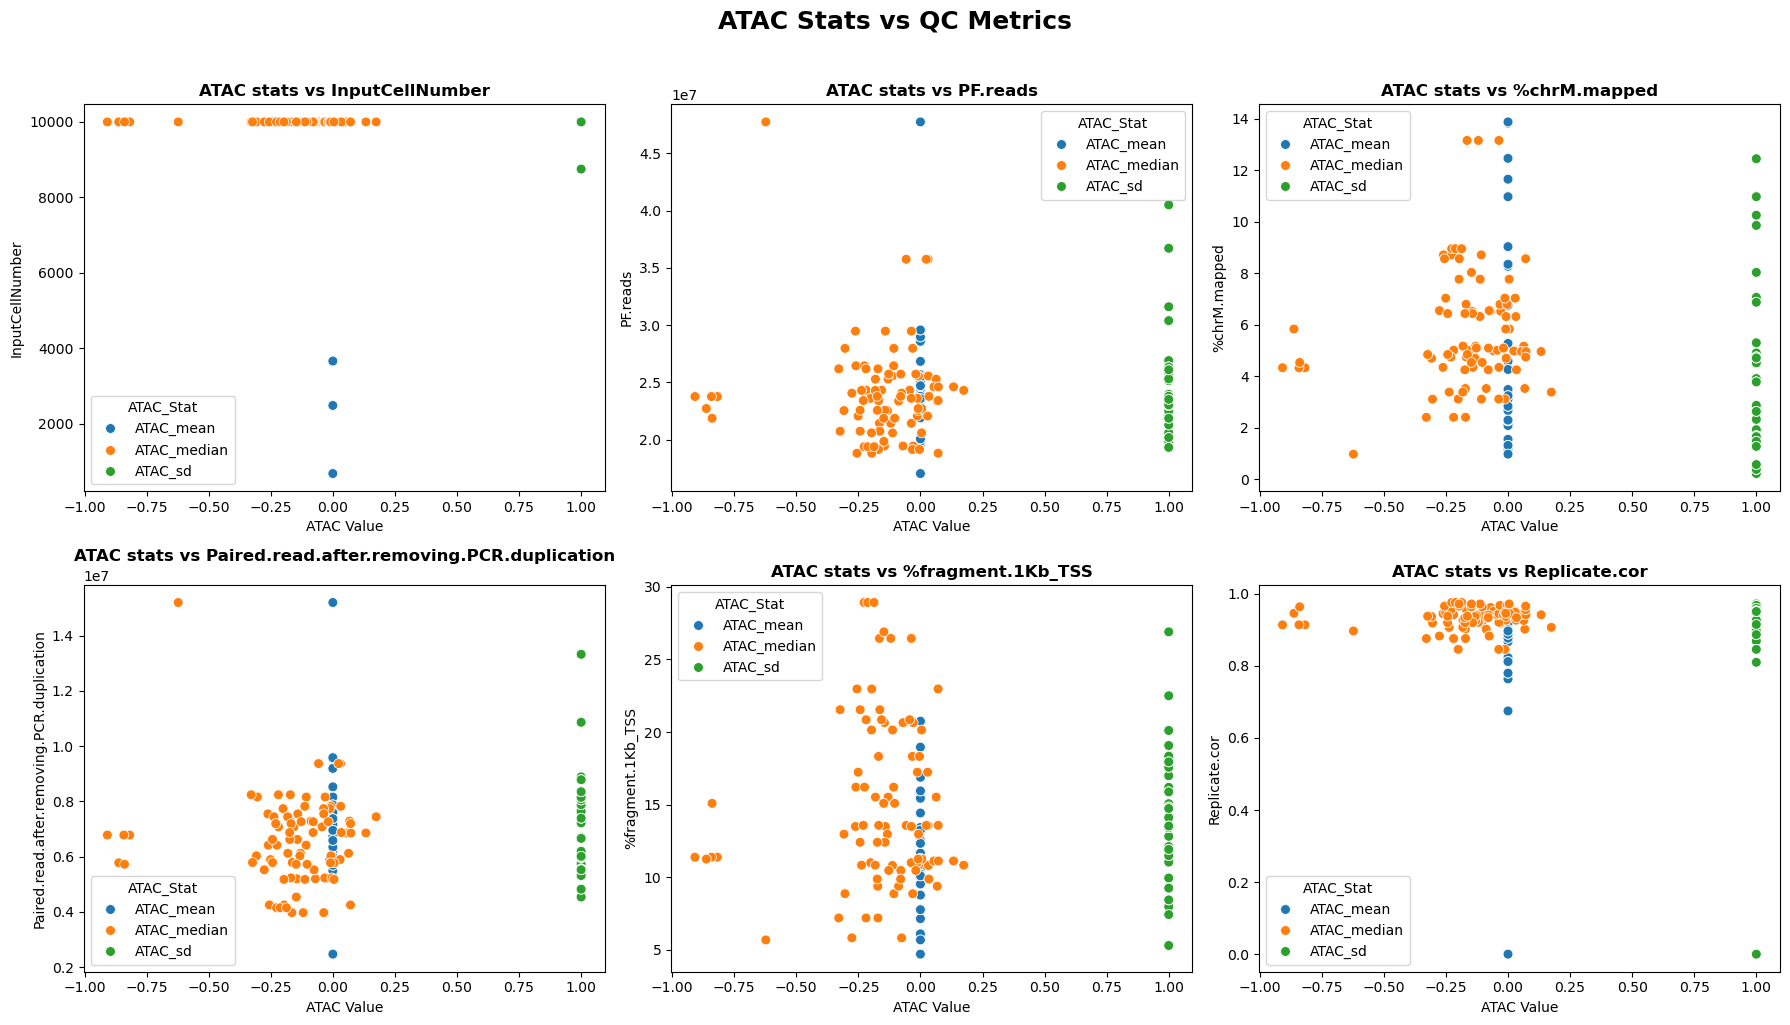

In [ ]:
# Spalten definieren
atac_vars = ['ATAC_mean', 'ATAC_median', 'ATAC_sd']
qc_vars = [col for col in ATAC_combined.columns if col not in atac_vars + ['CellType']]

# Data vorbereiten
subset = ATAC_combined[atac_vars + qc_vars].dropna()

# Melted long-form DataFrame (wie vorher)
atac_long = subset[atac_vars + qc_vars].melt(value_vars=atac_vars, 
                                              var_name='ATAC_Stat', 
                                              value_name='ATAC_Value')
qc_long = subset[qc_vars]
qc_long = qc_long.loc[qc_long.index.repeat(len(atac_vars))].reset_index(drop=True)
atac_long = pd.concat([atac_long, qc_long], axis=1)

# Plot Setup: 3 Spalten
n_qc = len(qc_vars)
cols = 3
rows = math.ceil(n_qc / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
axes = axes.flatten()

# Für jede QC-Spalte ein Plot
for i, qc in enumerate(qc_vars):
    ax = axes[i]
    sns.scatterplot(data=atac_long, x='ATAC_Value', y=qc, hue='ATAC_Stat', ax=ax, s=50)
    ax.set_title(f"ATAC stats vs {qc}", fontsize=12, fontweight='bold')
    ax.set_xlabel("ATAC Value")
    ax.set_ylabel(qc)

# Leere Subplots ausblenden, falls #QC-Spalten kein Vielfaches von 3 ist
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Gesamt-Titel und Layout
fig.suptitle("ATAC Stats vs QC Metrics", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("figures/ATAC_Stats_vs_QC.png", dpi=300, bbox_inches="tight")
plt.show()


### b) Should some cell types be removed or normalized?

In [137]:
#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

#group QC/ 
QC_mean = QC_conv_num.groupby("CellType").mean()

#link mean values with the QC data
ATAC_combined = pd.merge(ATAC_mean_df, QC_mean, on='CellType')
ATAC_combined = ATAC_combined.rename(columns={0: "ATAC_mean"})

ATAC_combined.head()


,CellType,ATAC_mean,InputCellNumber,PF.reads,%chrM.mapped,Paired.read.after.removing.PCR.duplication,%fragment.1Kb_TSS,Replicate.cor
0,LTHSC.34-.BM,-3.077323e-16,677.0,22287984.0,4.580,2470102.0,10.600,NaN
1,LTHSC.34+.BM,6.387524e-17,2483.0,28588536.0,3.170,7675501.0,7.700,NaN
2,STHSC.150-.BM,7.474290e-17,3660.0,22170346.0,3.250,6060045.0,11.130,NaN
3,MPP4.135+.BM,-3.586606e-16,10000.0,24003590.0,13.830,6128252.0,18.960,NaN
4,proB.CLP.BM,1.660645e-16,10000.0,21903414.0,9.035,6347376.5,15.605,0.868


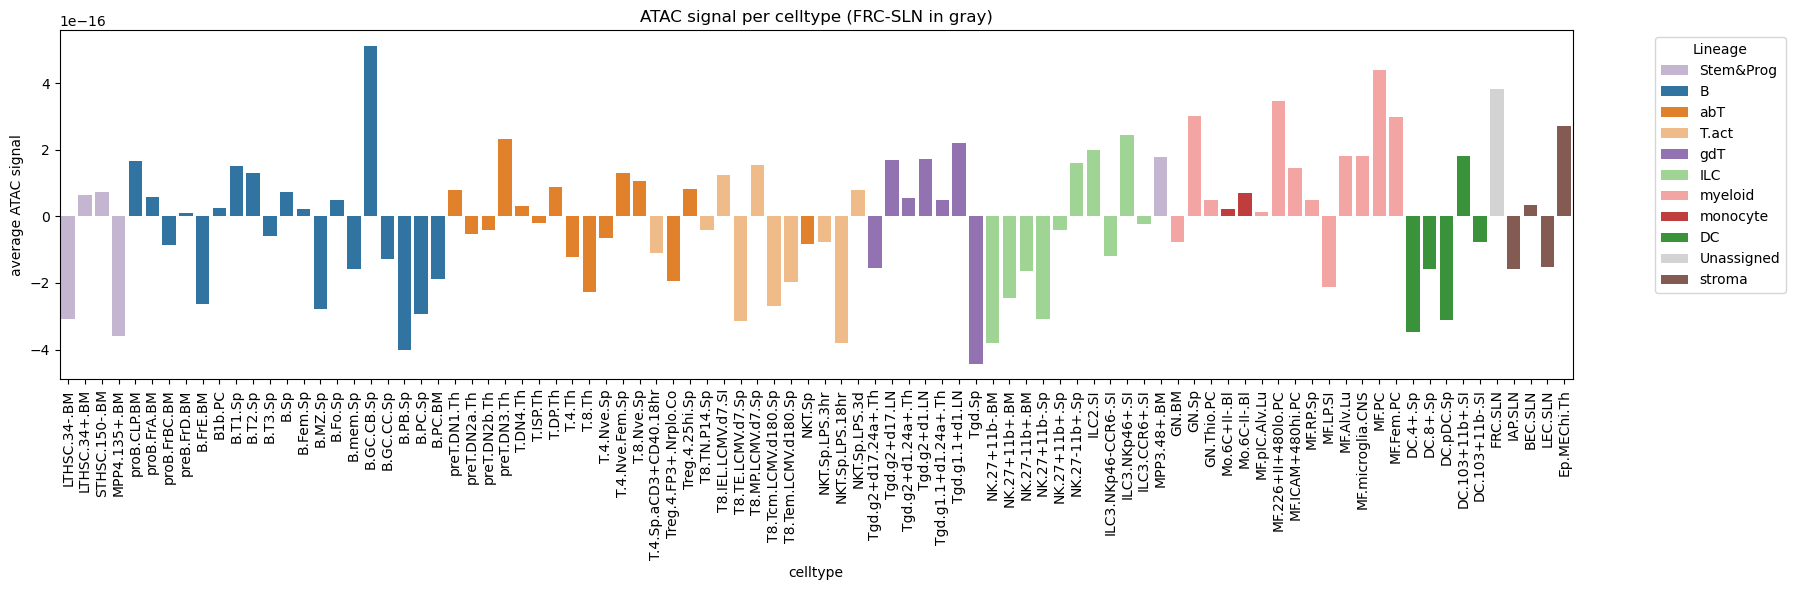

In [138]:
#ATAC means into data frame
ATAC_mean_df = celltype_means.reset_index()
ATAC_mean_df.columns = ['CellType', 'ATAC_mean']

# specific color for each celltype
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC_unique = QC.drop_duplicates(subset="CellType")
ATAC_mean_df["Lineage"] = ATAC_mean_df["CellType"].map(QC_unique.set_index("CellType")["Lineage"])

# color for FRC.SLN (no lineage assigned)
ATAC_mean_df["Lineage"] = ATAC_mean_df["Lineage"].fillna("Unassigned")

from lineage_colors import lineage_colors

#boxplot: ATAC signal for all celltypes
plt.figure(figsize=(18, 6))

sns.barplot(
    data=ATAC_mean_df,
    x="CellType",
    y="ATAC_mean",
    hue="Lineage",
    palette=lineage_colors,
    dodge=False
)
plt.xticks(rotation=90)
plt.title("ATAC signal per celltype (FRC-SLN in gray)")
plt.ylabel("average ATAC signal")
plt.xlabel("celltype")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Lineage")
plt.tight_layout()
plt.savefig("figures/mean_ATAC_peaks.png", dpi=300, bbox_inches="tight")
plt.show()

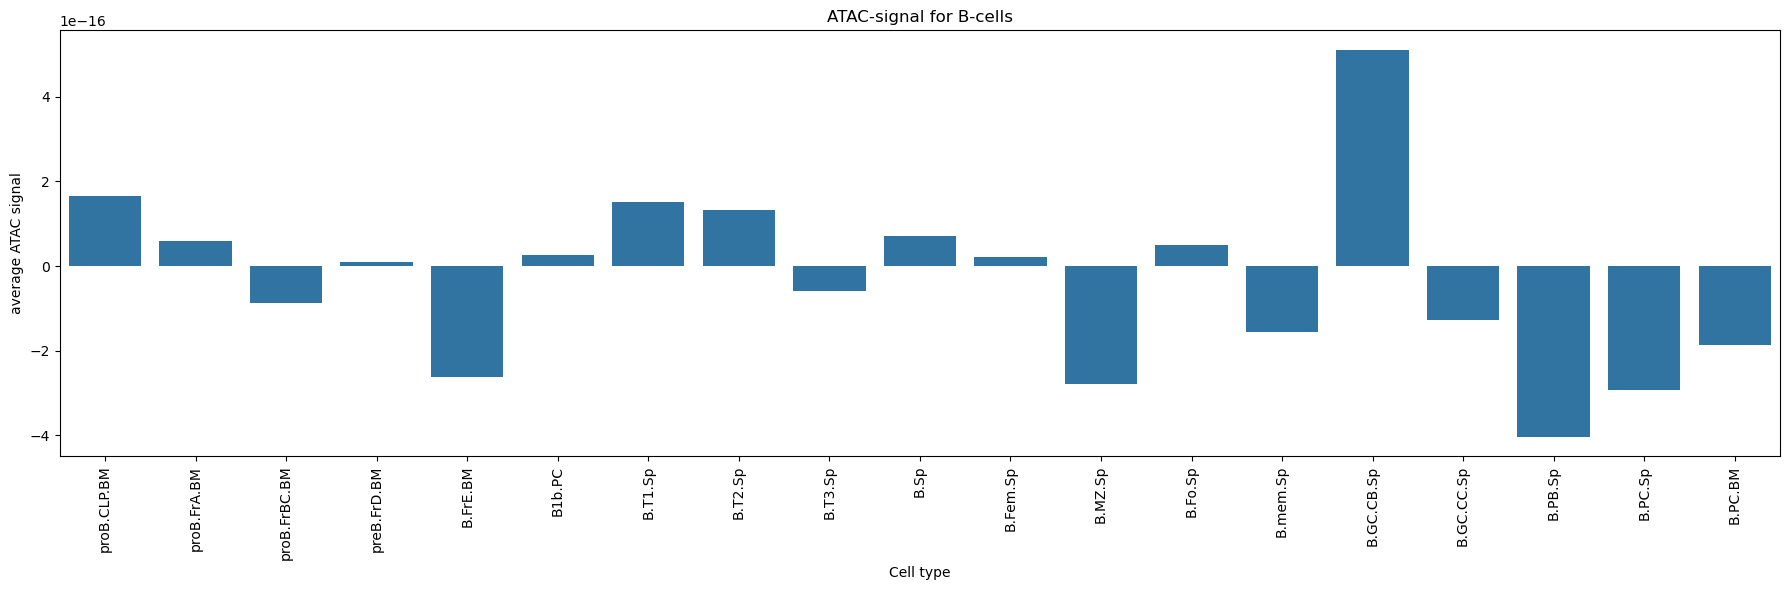

In [139]:
# load and prepare QC-matric
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# isolate only B-cell types of QC-matric
b_cell_types = QC[QC["Lineage"] == "B"]["CellType"].tolist()

# isolate only B-cell types of ATAC_mean_df 
b_cells = ATAC_mean_df[ATAC_mean_df["CellType"].isin(b_cell_types)]

# boxpot
plt.figure(figsize=(18, 6))

sns.barplot(
    data=b_cells,
    x="CellType",
    y="ATAC_mean",
    color=(0.121569, 0.466667, 0.705882)
)

plt.xticks(rotation=90)
plt.title("ATAC-signal for B-cells")
plt.ylabel("average ATAC signal")
plt.xlabel("Cell type")
plt.tight_layout()
plt.show()



Celltypes containing a very low signal: LTHSC.34-BM
->should be removed/normalized

### ii. How variable is the chromatin signal for CREs across cells?

### a) Should peaks be removed due to lack of signal?

To solve this we did a Histogram with the mean signal across all samples for each Peak. With that we could find peaks that give no signal in the most cells -> chromatin is always closed 

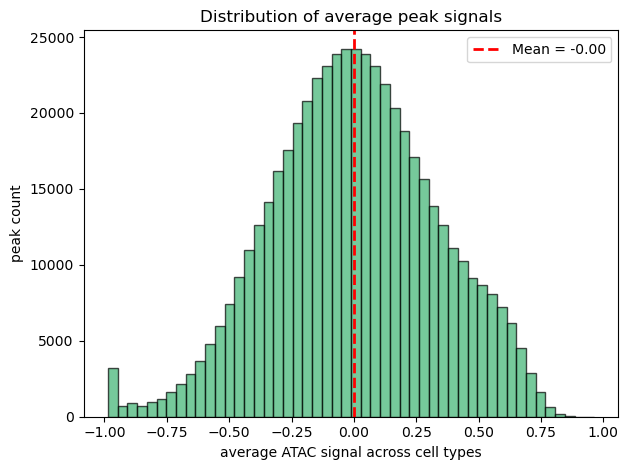

In [140]:
signal_columns = ATAC_scaled.columns[2:92] 

# Mean across these columns (per row)
ATAC_scaled["peak_mean_signal"] = ATAC_scaled[signal_columns].mean(axis=1)

# Histogram of the mean of all peaks
plt.hist(ATAC_scaled["peak_mean_signal"].dropna(), bins=50, color="mediumseagreen", edgecolor="black", alpha=0.7)
plt.axvline(ATAC_scaled["peak_mean_signal"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Mean = {ATAC_scaled['peak_mean_signal'].mean():.2f}")
plt.xlabel("average ATAC signal across cell types")
plt.ylabel("peak count")
plt.title("Distribution of average peak signals")
plt.legend()
plt.tight_layout()
plt.savefig("figures/Distribution_of_ATAC_peaks.png", dpi=300, bbox_inches="tight")
plt.show()

In [141]:
# extract peaks with a low mean -> low signal
low_signal_peaks = ATAC_scaled[ATAC_scaled["peak_mean_signal"] < -0.8]
print(f"count of peaks with low mean signal: {len(low_signal_peaks)}")
low_signal_peaks.head()#
#low_signal_peaks contains low peaks -> low signal -> could be removed 
#you can change the threshold (-0.8) to make it more/less stright


count of peaks with low mean signal: 6231


CellType,mm10.60way.phastCons_scores,_-log10_bestPvalue,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,proB.CLP.BM,proB.FrA.BM,proB.FrBC.BM,preB.FrD.BM,...,DC.8+.Sp,DC.pDC.Sp,DC.103+11b+.SI,DC.103+11b-.SI,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th,peak_mean_signal
31,0.812861,1.052346,-0.622619,-0.913378,-0.818063,-0.843321,-0.960137,-0.931487,-0.956155,1.334373,...,-0.867550,-1.047149,-0.903951,-0.842635,-0.343229,1.629110,-0.984936,0.062004,-0.887283,-0.811659
157,-0.219575,-1.319972,-0.610870,-0.903412,-0.812874,-0.838477,-0.955131,-0.927534,-0.953318,-1.101394,...,-0.861118,-1.042502,-0.899507,-0.837118,-0.987176,-0.926804,-0.979376,-1.155704,-0.879998,-0.983202
202,-0.121248,-1.320812,-0.618935,-0.909541,-0.816399,1.869355,-0.957918,-0.929453,-0.954753,-1.102748,...,-0.864847,-1.045179,-0.901671,-0.840177,-0.992575,-0.929080,-0.982825,-1.160350,-0.885439,-0.928467
244,1.107843,-1.320028,-0.617497,-0.908961,-0.815396,-0.839791,-0.955895,-0.927686,-0.953735,-1.101565,...,-0.864280,-1.043088,-0.900400,-0.839229,-0.991237,-0.928063,-0.980665,-1.159527,-0.882420,-0.958114
376,-0.121248,-1.315507,-0.607421,-0.897997,-0.808945,-0.831966,-0.950401,-0.921339,-0.948010,-1.097311,...,-0.857653,-1.038799,-0.896384,-0.833196,-0.984775,-0.921065,-0.974421,-1.152730,-0.876771,-0.978404


### b) Do promoters exhibit specific signals vs enhancers?

In [142]:
Annotation = pd.read_csv("data/Transcript, Coding, and Exon Start and End Positions.CSV", sep=";")
Annotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47382 entries, 0 to 47381
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gene Name               47382 non-null  object
 1   Transcript Name         47382 non-null  object
 2   Chromosome              47382 non-null  object
 3   Strand                  47382 non-null  object
 4   5' transcript Start     47382 non-null  int64 
 5   3' Transcript Start     47382 non-null  int64 
 6   Coding Region 5' Start  47382 non-null  int64 
 7   Coding Region 3' Start  47382 non-null  int64 
 8   Exon Count              47382 non-null  int64 
 9   Exon Starts             47382 non-null  object
 10  Exon Ends               47382 non-null  object
dtypes: int64(5), object(6)
memory usage: 4.0+ MB


In [143]:
Annotation.head()

,Gene Name,Transcript Name,Chromosome,Strand,5' transcript Start,3' Transcript Start,Coding Region 5' Start,Coding Region 3' Start,Exon Count,Exon Starts,Exon Ends
0,Wdsub1,NM_001159636,chr2,-,59855193,59882606,59855270,59878527,11,"59855193,59858609,59861560,59862619,59862816,5...","59855275,59858750,59861737,59862726,59862857,5..."
1,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3..."
2,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3..."
3,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294..."
4,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,"


In [144]:
#names of coloumns
for col in Annotation.columns:
    print(repr(col))

'Gene Name'
'Transcript Name'
'Chromosome'
'Strand'
"5' transcript Start"
"3' Transcript Start "
"Coding Region 5' Start"
"Coding Region 3' Start"
'Exon Count'
'Exon Starts '
'Exon Ends'


In [192]:
#create promotor annotation 
def promoter_regions(row):
    if row["Strand"] == "+":
        start = row["5' transcript Start"] - 100
        end = row["5' transcript Start"] + 100
    else:
        start = row["3' Transcript Start "] - 100
        end = row["3' Transcript Start "] + 100
    return pd.Series({"Chromosome": row["Chromosome"],"Start": start,"End": end,"Gene Name": row["Gene Name"]})

#add gene names 
promoters = Annotation.apply(promoter_regions, axis=1)


In [197]:
#prepare ATAC peaks
peaks = pd.DataFrame({"Chromosome": ATAC["chrom"],"Start": ATAC["Summit"] - 100,"End": ATAC["Summit"] + 100,"peak_id": ATAC["ImmGenATAC1219.peakID"]})

In [198]:
#in PyRanges
promoter_ranges = pr.PyRanges(promoters)
peak_ranges = pr.PyRanges(peaks)

#Overlap
promoter_overlap = peak_ranges.join(promoter_ranges)

#IDs of peaks in promoters
promoter_peak_ids = promoter_overlap.df['peak_id'].unique()

# new coloumn: 'region' initial with 'Enhancer'
ATAC['region'] = 'Enhancer'

# Peaks with promotor
ATAC.loc[ATAC['ImmGenATAC1219.peakID'].isin(promoter_peak_ids), 'region'] = 'Promoter'


In [199]:
#check if its numerical 
print(ATAC.iloc[:, 8:].dtypes)

LTHSC.34-.BM     float64
LTHSC.34+.BM     float64
STHSC.150-.BM    float64
MPP4.135+.BM     float64
proB.CLP.BM      float64
                  ...   
Start              int64
End                int64
mean_signal      float64
is_intronic         bool
region            object
Length: 95, dtype: object


In [202]:
#check promotor/enhancer
print(ATAC['region'].value_counts())

region
Enhancer    492717
Promoter     19878
Name: count, dtype: int64


In [205]:
# calculate mean signals per peak
signal_cols = ATAC.select_dtypes(include=["float64", "int64"]).columns
ATAC['mean_signal'] = ATAC[signal_cols].mean(axis=1)

#check for inf and replace 
np.isinf(ATAC["mean_signal"]).sum()
ATAC["mean_signal"] = ATAC["mean_signal"].replace([np.inf, -np.inf], np.nan)


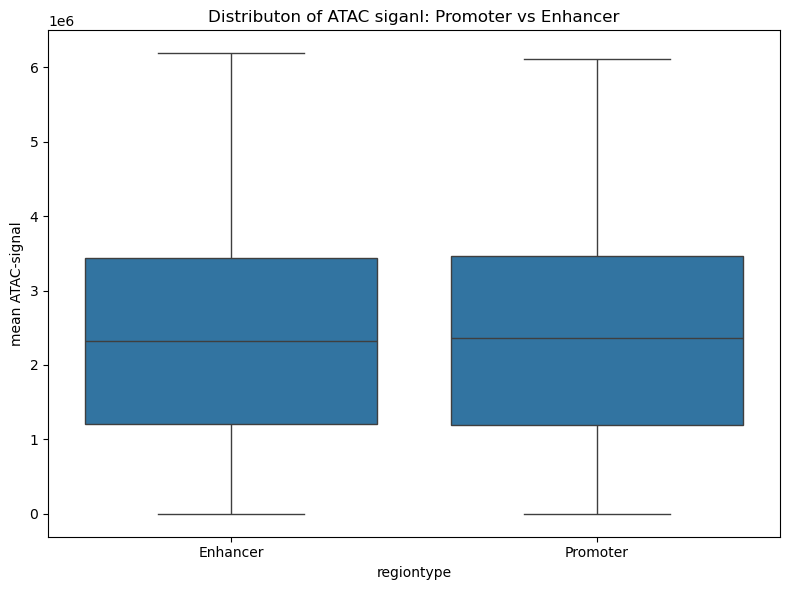

In [206]:
# Plot
plt.figure(figsize=(8,6))
sns.boxplot(data=ATAC, x='region', y='mean_signal')
plt.title("Distributon of ATAC siganl: Promoter vs Enhancer")
plt.ylabel("mean ATAC-signal")
plt.xlabel("regiontype")
plt.tight_layout()
plt.show()

Height and median of the boxes seems similar 
-> Promoters do not show significantly different chromatin accessibility compared to enhancers in this dataset.
-> overall, promoter and enhancer regions probably have similar ATAC-seq signal levels.

In [207]:
#test
from scipy.stats import ttest_ind
prom = ATAC.loc[ATAC['region'] == 'Promoter', 'mean_signal']
enh = ATAC.loc[ATAC['region'] == 'Enhancer', 'mean_signal']
t_stat, p_val = ttest_ind(prom, enh, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.2e}")

T-statistic: nan, p-value: nan


### c) Is there a relationship between the signal and the distance to the TSS?

To answer this we examined if peaks closer to the Transcription Start Site (TSS) have higher/lower ATAC-seq signals. 

In [151]:
#extract  TSS positions 
def get_TSS(row):
    if row["Strand"] == "+":
        return row["5' transcript Start"]
    else:
        return row["3' Transcript Start "]

Annotation["TSS"] = Annotation.apply(get_TSS, axis=1)

#new data set with only needed coloumns
TSS = Annotation[["Gene Name", "Chromosome", "TSS"]].copy()
TSS.columns = ["Gene", "Chromosome", "TSS"]

TSS.head()


,Gene,Chromosome,TSS
0,Wdsub1,chr2,59882606
1,Rbm18,chr2,36136704
2,Prrc2b,chr2,32151147
3,Ildr2,chr1,166254138
4,Perm1,chr4,156215926


In [152]:
#prepare ATAC:
ATAC["Start"] = ATAC["Summit"]
ATAC["End"] = ATAC["Summit"] + 1

#only needed coloumns
ATAC_peaks = ATAC[["chrom", "Start", "End", "ImmGenATAC1219.peakID"]].copy()
ATAC_peaks.columns = ["Chromosome", "Start", "End", "peak_id"]

In [ ]:
#group Peaks und TSS one same chromosome
distance_list = []

for chrom in ATAC_peaks['Chromosome'].unique():
    peaks_chr = ATAC_peaks[ATAC_peaks["Chromosome"] == chrom].copy()
    tss_chr = TSS[TSS["Chromosome"] == chrom]

    if len(tss_chr) == 0 or len(peaks_chr) == 0:
        continue

    #prep  Arrays 
    peak_positions = peaks_chr["Start"].values.reshape(-1, 1)
    tss_positions = tss_chr["TSS"].values.reshape(-1, 1)

    # kNN-Modell (find next TSS)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(tss_positions)
    dists, indices = nbrs.kneighbors(peak_positions)

    #save distance
    peaks_chr['distance_to_TSS'] = dists.flatten()
    distance_list.append(peaks_chr[['peak_id', 'distance_to_TSS']])
                         
distance = pd.concat(distance_list)  

distance.head()

,peak_id,distance_to_TSS
0,ImmGenATAC1219.peak_1,650712.0
1,ImmGenATAC1219.peak_2,584272.0
2,ImmGenATAC1219.peak_3,551389.0
3,ImmGenATAC1219.peak_4,550013.0
4,ImmGenATAC1219.peak_5,298711.0


In [154]:
#add distance in ATAC
ATAC_dis = ATAC.merge(distance[['peak_id', 'distance_to_TSS']], left_on='ImmGenATAC1219.peakID', right_on='peak_id', how='left')
ATAC_dis.head()

,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,...,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th,region,mean_signal,Start,End,peak_id,distance_to_TSS
0,ImmGenATAC1219.peak_1,chr1,3020786,0.00,0.56,NaN,NaN,NaN,0.41,0.71,...,0.10,0.57,46447.0,14977.00,Enhancer,45113.170215,3020786,3020787,ImmGenATAC1219.peak_1,650712.0
1,ImmGenATAC1219.peak_2,chr1,3087226,0.00,0.50,NaN,NaN,NaN,0.41,23377.00,...,0.98,42401.00,12451.0,0.94,Enhancer,42780.219677,3087226,3087227,ImmGenATAC1219.peak_2,584272.0
2,ImmGenATAC1219.peak_3,chr1,3120109,0.07,45879.00,1.0,NaN,NaN,13181.00,0.10,...,33817.00,12055.00,45748.0,0.11,Enhancer,41022.576915,3120109,3120110,ImmGenATAC1219.peak_3,551389.0
3,ImmGenATAC1219.peak_4,chr1,3121485,0.15,45691.00,1.0,NaN,NaN,0.41,0.10,...,0.98,46753.00,45748.0,0.11,Enhancer,42544.601383,3121485,3121486,ImmGenATAC1219.peak_4,550013.0
4,ImmGenATAC1219.peak_5,chr1,3372787,0.03,11324.00,NaN,NaN,NaN,0.41,0.10,...,0.75,12055.00,22282.0,45781.00,Enhancer,47175.667742,3372787,3372788,ImmGenATAC1219.peak_5,298711.0


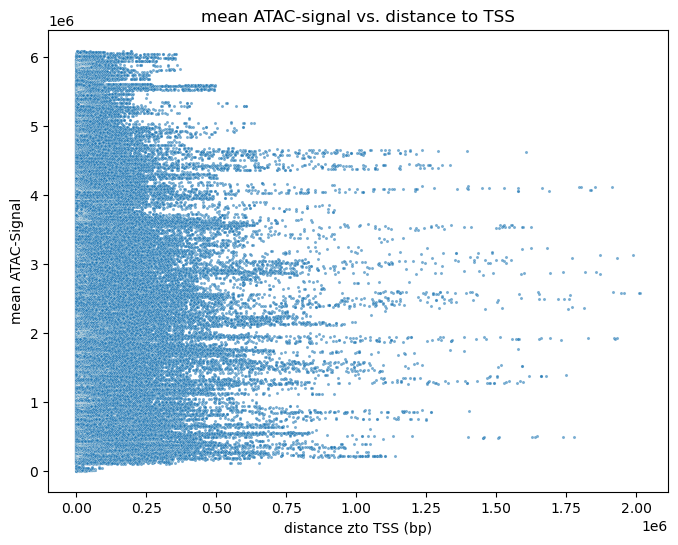

In [155]:
# calculate mean signals per peak
signal_cols = ATAC_dis.select_dtypes(include=["float64", "int64"]).columns
ATAC_dis['mean_signal'] = ATAC_dis[signal_cols].mean(axis=1)

# data and remove NAs
df = ATAC_dis[['mean_signal', 'distance_to_TSS']].dropna()

# scatterplot
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='distance_to_TSS', y='mean_signal', alpha=0.6, s=5,)

plt.xlabel('distance zto TSS (bp)')
plt.ylabel('mean ATAC-Signal')
plt.title('mean ATAC-signal vs. distance to TSS')
plt.show()

In [156]:
#correlation
corr = df.corr().loc['mean_signal', 'distance_to_TSS']
print(f"Pearson-Korrelation: {corr:.3f}")

Pearson-Korrelation: -0.045


### d) Are intronic enhancers different from enhancers outside the transcript.

To find out if whether intornic enhacners (inside of transcripts) are different from enhancers outside the transcript we first extracted the Transcript regions out of the Annotation data

In [157]:
#only coloumns with needed information 
transcripts = Annotation[["Chromosome", "5' transcript Start", "3' Transcript Start ", "Gene Name", "Strand"]].copy()

#rename for similar names 
transcripts.columns = ["chr", "start", "end", "gene", "strand"]

#check:  start < end (no difference between +, - because we just want to know if its within)
transcripts["tx_start"] = transcripts[["start", "end"]].min(axis=1)
transcripts["tx_end"] = transcripts[["start", "end"]].max(axis=1)

#final data
transcripts = transcripts[["chr", "tx_start", "tx_end", "gene"]]
transcripts.head()


,chr,tx_start,tx_end,gene
0,chr2,59855193,59882606,Wdsub1
1,chr2,36116078,36136704,Rbm18
2,chr2,32151147,32234537,Prrc2b
3,chr1,166254138,166316832,Ildr2
4,chr4,156215926,156221307,Perm1


In [159]:
#Tree per chromosome
trees = defaultdict(IntervalTree)

for _, row in transcripts.iterrows():
    trees[row["chr"]].add(Interval(row["tx_start"], row["tx_end"], data=row["gene"]))


In [160]:
#prep ATAC-Peaks
ATAC["Start"] = ATAC["Summit"]
ATAC["End"] = ATAC["Summit"] + 1

In [161]:
#classifiy: Intronic?
def is_intronic(row):
    chrom = row["chrom"]
    start = row["Start"]
    end = row["End"]
    return len(trees[chrom].overlap(start, end)) > 0

ATAC["is_intronic"] = ATAC.apply(is_intronic, axis=1)
ATAC.head()


,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,LTHSC.34-.BM,LTHSC.34+.BM,...,FRC.SLN,IAP.SLN,BEC.SLN,LEC.SLN,Ep.MEChi.Th,region,mean_signal,Start,End,is_intronic
0,ImmGenATAC1219.peak_1,chr1,3020786,0.00,0.56,NaN,NaN,NaN,0.41,0.71,...,46388.00,0.10,0.57,46447.0,14977.00,Enhancer,45113.170215,3020786,3020787,False
1,ImmGenATAC1219.peak_2,chr1,3087226,0.00,0.50,NaN,NaN,NaN,0.41,23377.00,...,0.92,0.98,42401.00,12451.0,0.94,Enhancer,42780.219677,3087226,3087227,False
2,ImmGenATAC1219.peak_3,chr1,3120109,0.07,45879.00,1.0,NaN,NaN,13181.00,0.10,...,63.38,33817.00,12055.00,45748.0,0.11,Enhancer,41022.576915,3120109,3120110,False
3,ImmGenATAC1219.peak_4,chr1,3121485,0.15,45691.00,1.0,NaN,NaN,0.41,0.10,...,45790.00,0.98,46753.00,45748.0,0.11,Enhancer,42544.601383,3121485,3121486,False
4,ImmGenATAC1219.peak_5,chr1,3372787,0.03,11324.00,NaN,NaN,NaN,0.41,0.10,...,0.92,0.75,12055.00,22282.0,45781.00,Enhancer,47175.667742,3372787,3372788,True


In [162]:
ATAC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512595 entries, 0 to 512594
Columns: 103 entries, ImmGenATAC1219.peakID to is_intronic
dtypes: bool(1), float64(94), int64(3), object(5)
memory usage: 399.4+ MB


In [163]:
#check for inf and replace 
np.isinf(ATAC["mean_signal"]).sum()
ATAC["mean_signal"] = ATAC["mean_signal"].replace([np.inf, -np.inf], np.nan)

In [164]:
# compare mean 
intronic_mean = ATAC[ATAC["is_intronic"]]["mean_signal"].mean()
non_intronic_mean = ATAC[~ATAC["is_intronic"]]["mean_signal"].mean()

print("Intronic Enhancer mean:", round(intronic_mean, 3))
print("Non-intronic Enhancer mean:", round(non_intronic_mean, 3))


Intronic Enhancer mean: 829908.197
Non-intronic Enhancer mean: 827764.297


In [209]:
#category names for plot
ATAC_plot = ATAC.copy()
ATAC_plot["Enhancer Type"] = ATAC_plot["is_intronic"].map({True: "Intronic", False: "Non-intronic"})

C:\Users\Celine\AppData\Local\Temp\ipykernel_3048\1445846245.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ATAC_plot, x="Enhancer Type", y="mean_signal", palette="Set2")


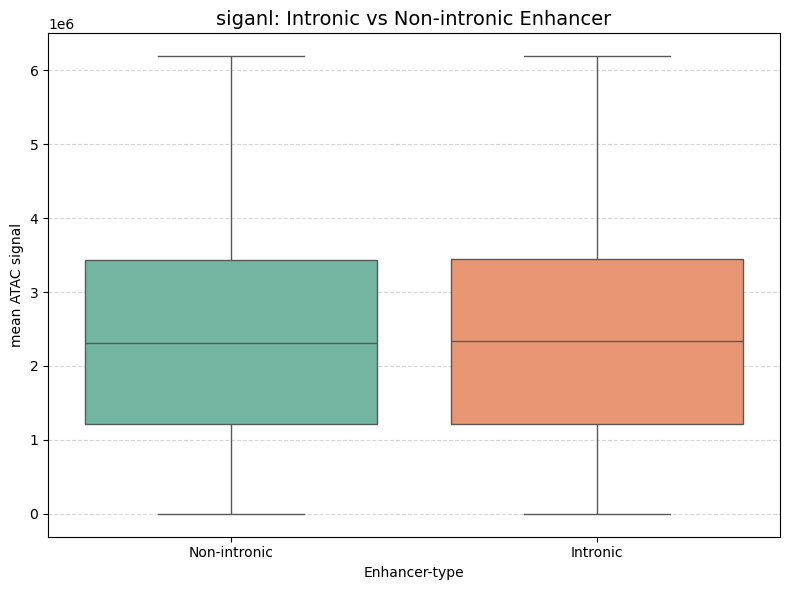

In [208]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=ATAC_plot, x="Enhancer Type", y="mean_signal", palette="Set2")

plt.title("siganl: Intronic vs Non-intronic Enhancer", fontsize=14)
plt.xlabel("Enhancer-type")
plt.ylabel("mean ATAC signal")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## iii. Do related cell types cluster together based on ATAC signal?

### a) Does clustering reproduce known relationship?

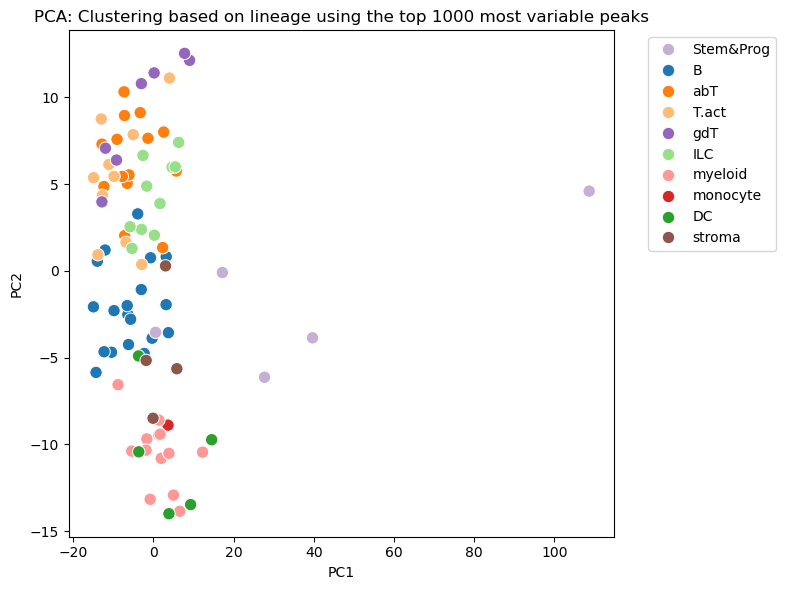

In [166]:
# top 1000 variable peaks
variances = ATAC_scaled.var(axis=1)  # Zeilen = Peaks, da transponiert
top_peaks = variances.sort_values(ascending=False).head(1000).index
ATAC_reduced = ATAC_scaled.loc[top_peaks]  # Subset auf 1000 Peaks

# samples = rows
df_pca_input = ATAC_reduced.T

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca_input)

# save in dataframe
df_pca = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=df_pca_input.index)

# celltype annotation
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()

# unique celltypes
qc_unique = QC.drop_duplicates(subset="CellType", keep="first")

# carry out mapping safely
df_pca["Lineage"] = df_pca.index.map(qc_unique.set_index("CellType")["Lineage"])

# plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Lineage", palette=lineage_colors, s=80)
plt.title("PCA: Clustering based on lineage using the top 1000 most variable peaks")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/PCA.png", dpi=300, bbox_inches="tight")
plt.show()


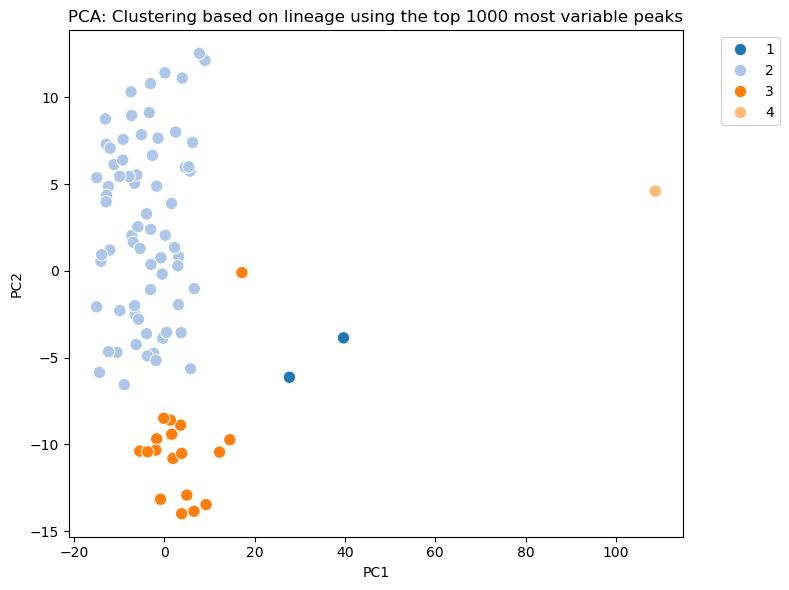

In [ ]:
# the there is a outlier at the top of the plot, which we want to remove, because it is not in the upper pca either
df_pca_without_outliner = df_pca.loc[(df_pca["PC2"] <= 15)].copy()

# clustering by coloring the clusters for comparison
Z = linkage(df_pca_without_outliner[['PC1','PC2']], method='average', metric='euclidean')

# cut into 2 clusters:
df_pca_without_outliner['cluster'] = fcluster(Z, t=4, criterion='maxclust')


plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_without_outliner, x="PC1", y="PC2", hue="cluster", palette="tab20", s=80)
plt.title("PCA: Clustering based on lineage using the top 1000 most variable peaks")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/PCA_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [55.0, 55.0, 72.5, 72.5],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [63.75, 63.75, 102.5, 102.5],
  [40.0, 40.0, 83.125, 83.125],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [125.0, 125.0, 142.5, 142.5],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [205.0, 205.0, 215.0, 215.0],
  [225.0, 225.0, 235.0, 235.0],
  [245.0, 245.0, 255.0, 255.0],
  [230.0, 230.0, 250.0, 250.0],
  [210.0, 210.0, 240.0, 240.0],
  [173.75, 173.75, 225.0, 225.0],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [290.0, 290.0, 310.0, 310.0],
  [270.0, 270.0, 300.0, 300.0],
  [325.0, 325.0, 335.0, 335.0],
  [355.0, 355.0, 365.0, 365.0],
  [345.0, 345.0, 360.0, 360.0],
  [330.0, 330.0, 352.5, 352.5],
  [385.0, 385.0, 395.0, 395.0],
  [405.0, 405.0, 4

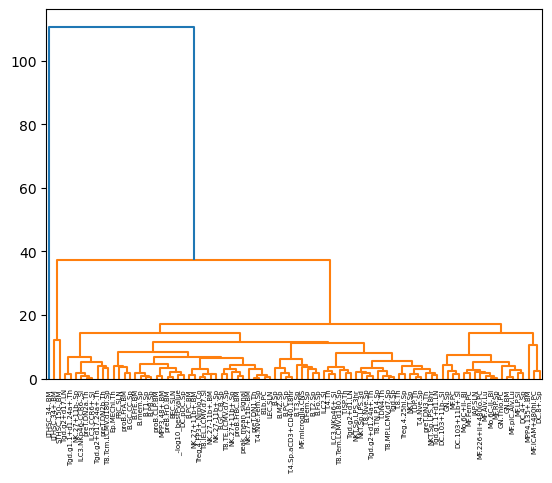

In [ ]:
# optimal number of clusters for our pca above: dendrogram
Z = linkage(df_pca_without_outliner[['PC1','PC2']], method='average', metric='euclidean')
dendrogram(Z, labels=df_pca_without_outliner.index, leaf_rotation=90)

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


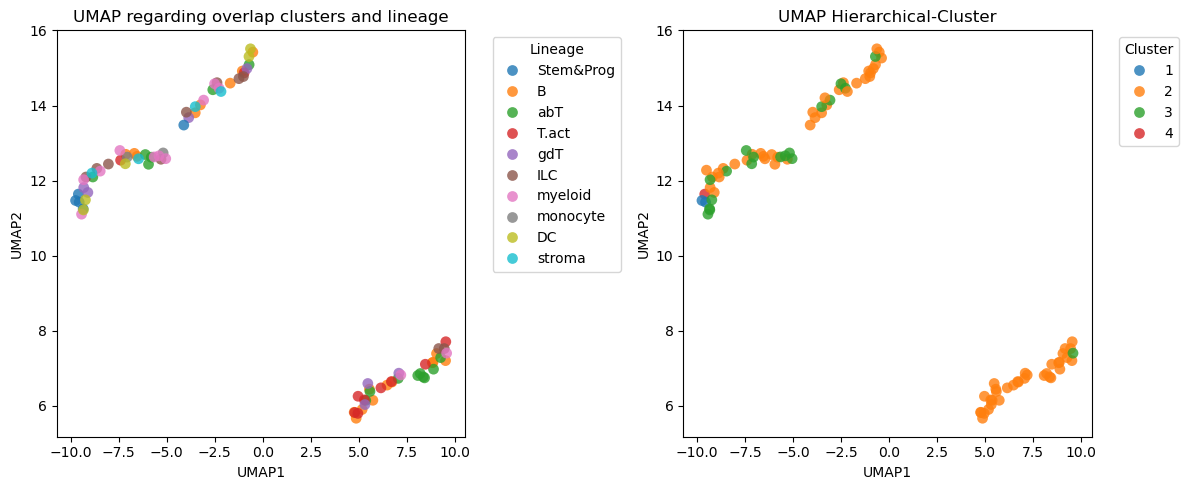

In [ ]:
# using UMAP to determine the overlap between the clusters and the true lineage

df_pca_without_outlier = df_pca[df_pca["PC1"] < 60].copy()

# should I do it with more than 2 PCs? If so, how many and how do I change them without an error?
pc_cols = [f"PC{i}" for i in range(1,2)]
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(df_pca_without_outliner[pc_cols])


df_pca_without_outliner.loc[:, "UMAP1"] = embedding[:, 0]
df_pca_without_outliner.loc[:, "UMAP2"] = embedding[:, 1]


fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.scatterplot(ax=axes[0],data=df_pca_without_outliner,x="UMAP1", y="UMAP2",hue="Lineage",palette="tab10", s=60,linewidth=0,alpha=0.8)
axes[0].set_title("UMAP regarding overlap clusters and lineage")
axes[0].legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Lineage")

sns.scatterplot(ax=axes[1],data=df_pca_without_outliner, x="UMAP1", y="UMAP2",hue="cluster",        palette="tab10",s=60,linewidth=0,alpha=0.8)
axes[1].set_title("UMAP Hierarchical‐Cluster")
axes[1].legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Cluster")

plt.tight_layout()
plt.savefig("figures/UMAP_clusters_lineage.png", dpi=300, bbox_inches="tight")
plt.show()

### Cell type vs Clusters (correlation)

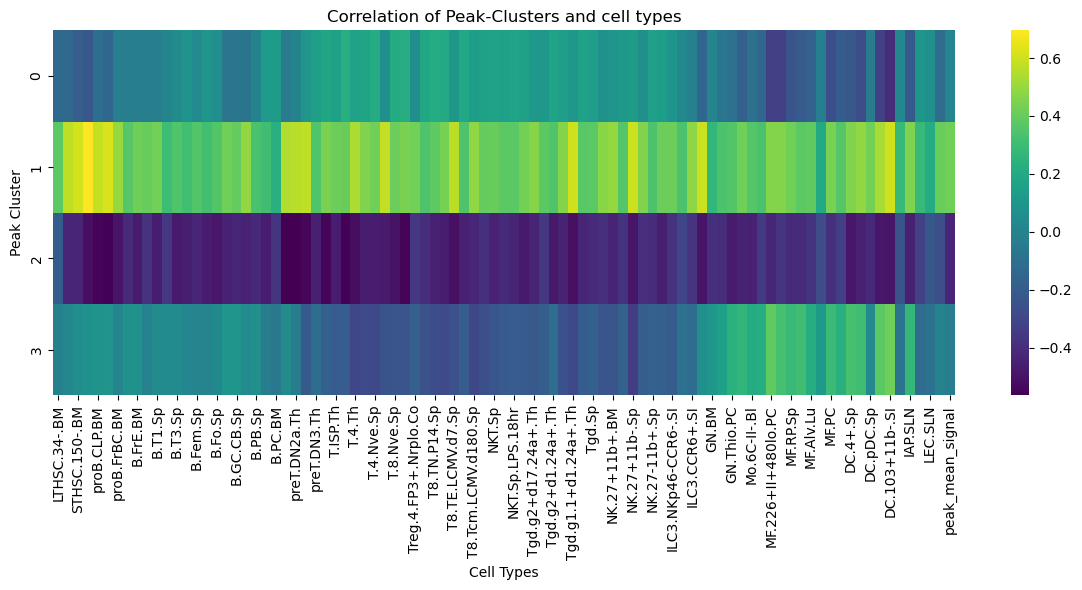

In [179]:
peak_labels = labels_4

peak_clusters = pd.DataFrame({
    'peak': ATAC_scaled_ct.index,
    'cluster': peak_labels
})

ATAC_scaled_ct_with_cluster = ATAC_scaled_ct.copy()
ATAC_scaled_ct_with_cluster['cluster'] = peak_clusters['cluster'].values

mean_signal_per_peak_cluster = ATAC_scaled_ct_with_cluster.groupby('cluster').mean()

plt.figure(figsize=(12, 6))
sns.heatmap(mean_signal_per_peak_cluster, cmap='viridis')
plt.title("Correlation of Peak-Clusters and cell types")
plt.xlabel("Cell Types")
plt.ylabel("Peak Cluster")
plt.tight_layout()
plt.savefig("figures/Correlation_Peak-Clusters_CellTypes.png", dpi=300, bbox_inches="tight")
plt.show()

## iv. Define different classes of peaks based on signal + variation

### a) Cluster CREs based on ATAC-signal

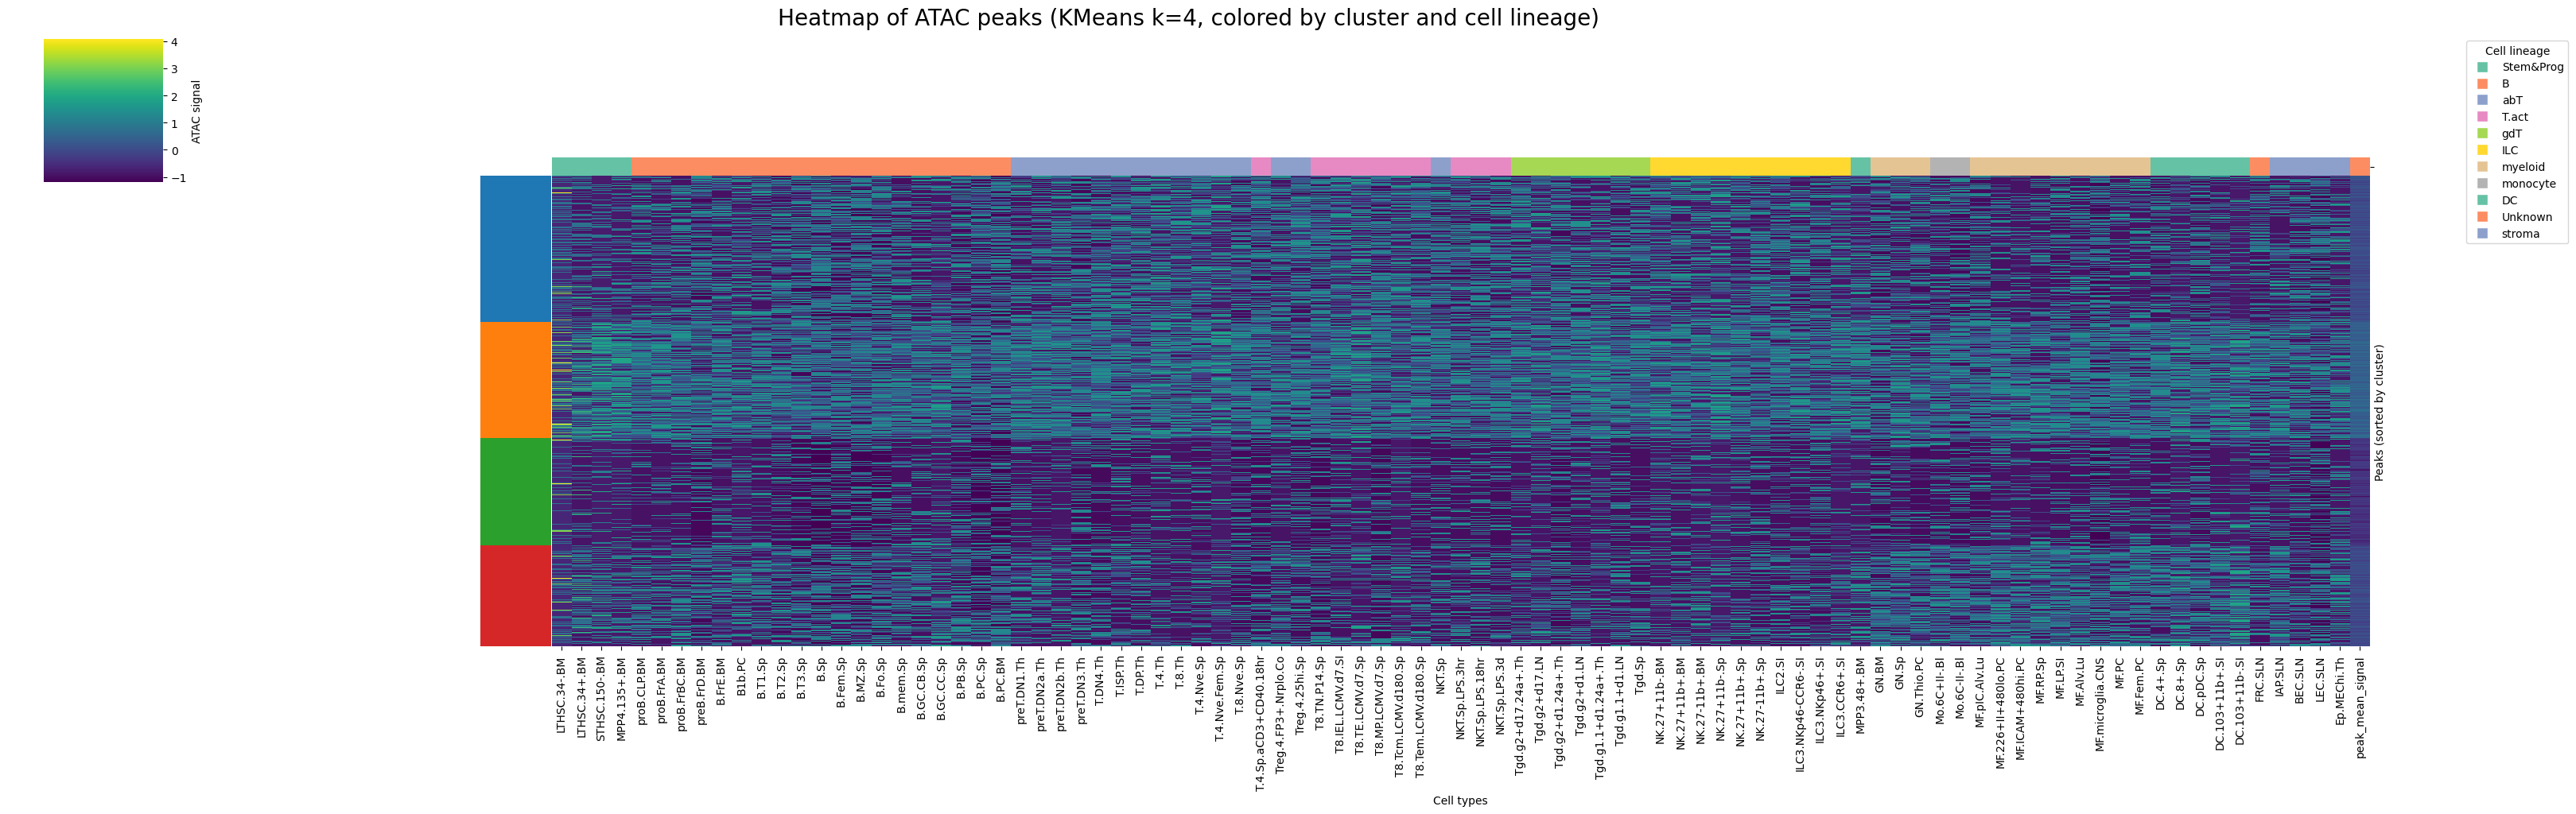

In [ ]:
# Add cluster labels to DataFrame
ATAC_scaled_ct["cluster"] = labels_4  # labels_4 = from KMeans(n_clusters=4)

# Sort peaks by cluster
ATAC_sorted = ATAC_scaled_ct.sort_values("cluster")

# Define cluster colors (e.g., 4 clusters)
cluster_colors = sns.color_palette("tab10", 4)
row_colors = [cluster_colors[i] for i in ATAC_sorted["cluster"]]

# Remove 'cluster' column for the heatmap itself
heatmap_data = ATAC_sorted.drop(columns="cluster")

# Load QC file to map cell types to lineages
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# Create mapping from cell type to lineage (one per cell type)
celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# Extract column names (= cell types) from heatmap_data
cell_types = heatmap_data.columns.tolist()

# Create column colors: map each cell type to its lineage color
lineages = [celltype_to_lineage.get(ct, "Unknown") for ct in cell_types]
unique_lineages = pd.unique(lineages)
palette = dict(zip(unique_lineages, sns.color_palette("Set2", len(unique_lineages))))
col_colors = pd.Series(lineages, index=cell_types).map(palette)

# Draw the heatmap
g = sns.clustermap(
    heatmap_data,
    cmap="viridis",
    yticklabels=False,
    row_colors=row_colors,
    col_colors=col_colors,
    col_cluster=False,
    row_cluster=False,
    figsize=(30, 10),
    cbar_kws={'label': 'ATAC signal'}
)

# Add title and axis labels
plt.suptitle("Heatmap of ATAC peaks (KMeans k=4, colored by cluster and cell lineage)", y=1.02, fontsize=20)
g.ax_heatmap.set_xlabel("Cell types")
g.ax_heatmap.set_ylabel("Peaks (sorted by cluster)")
g.ax_col_dendrogram.legend(
    handles=[plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=col, markersize=10, label=lab)
             for lab, col in palette.items()],
    title="Cell lineage",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.show()
palette

### b) Visualize behaviour of clustered regions

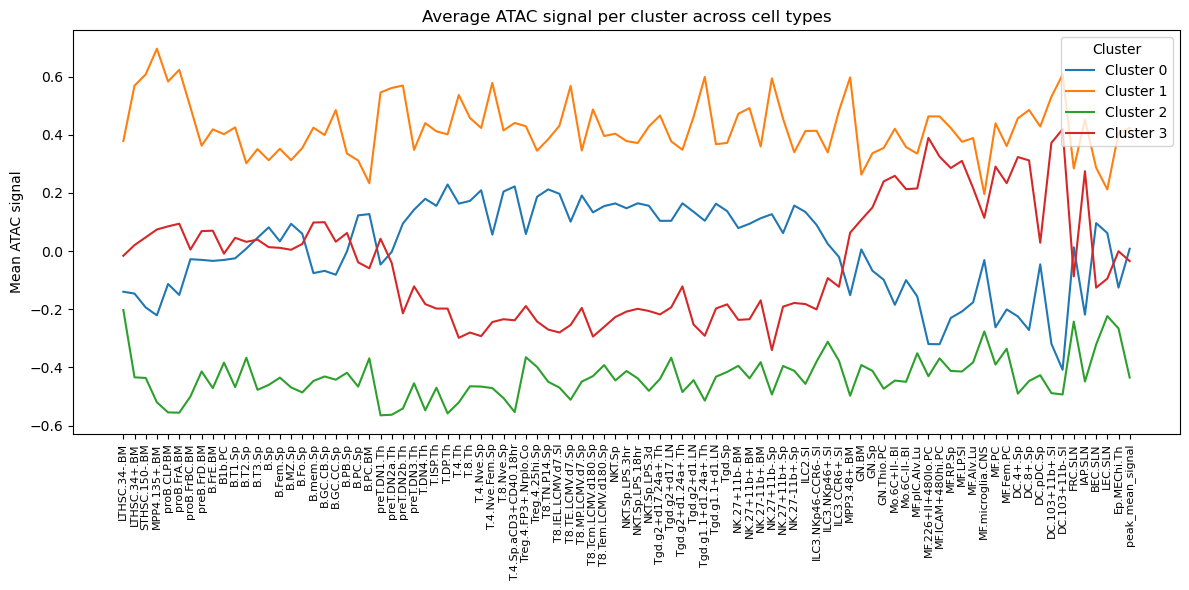

In [ ]:
# Reassign cluster labels
ATAC_scaled_ct["cluster"] = labels_4

# Group peaks by cluster and compute mean per cell type (column)
mean_per_cluster = ATAC_scaled_ct.groupby("cluster").mean()

# Line plot: signal trend across cell types
plt.figure(figsize=(12, 6))
for i in mean_per_cluster.index:
    plt.plot(mean_per_cluster.columns, mean_per_cluster.loc[i], label=f'Cluster {i}')
plt.legend(title="Cluster")
plt.title("Average ATAC signal per cluster across cell types")
plt.ylabel("Mean ATAC signal")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

### c) Define cell lineage-specific CRE clusters

/opt/miniconda3/envs/envBCells1/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


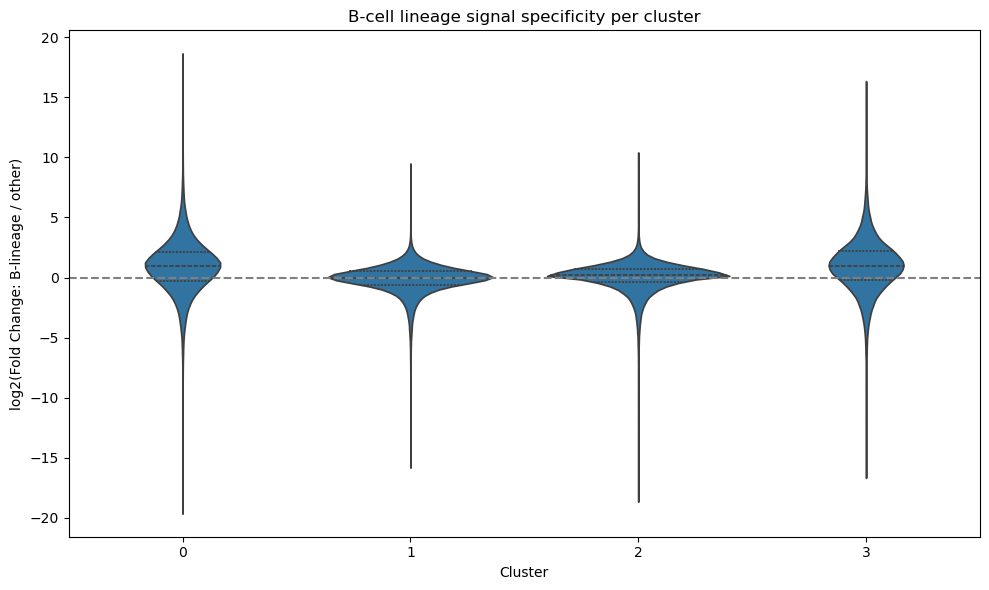

B-lineage-specific clusters: [0, 3]


In [ ]:
# Load QC file to map cell types to lineage 
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

# Get cell types assigned to the B-cell lineage 
b_lineage_celltypes = QC[QC["Lineage"] == "B"]["CellType"].tolist()

# Separate signal matrix and clusters 
signal_data = ATAC_scaled_ct.drop(columns="cluster")
clusters = ATAC_scaled_ct["cluster"]

# Filter columns for B-cells based on QC file 
b_cell_cols = [col for col in signal_data.columns if col in b_lineage_celltypes]
other_cols = [col for col in signal_data.columns if col not in b_cell_cols]

# Safety check
if len(b_cell_cols) == 0:
    raise ValueError("No B-lineage cell type columns found!")

# Calculate mean signal per peak 
b_signal = signal_data[b_cell_cols].mean(axis=1)
other_signal = signal_data[other_cols].mean(axis=1)

# Compute fold-change (B / others) 
fold_change = b_signal / (other_signal + 1e-9)

# Combine into DataFrame 
fc_cluster_df = pd.DataFrame({
    "fold_change": fold_change,
    "cluster": clusters
})

# Log2 transform for symmetry 
fc_cluster_df["log2_fc"] = np.log2(fc_cluster_df["fold_change"] + 1e-9)

# Violin plot: B-cell specificity per cluster 
plt.figure(figsize=(10,6))
sns.violinplot(x="cluster", y="log2_fc", data=fc_cluster_df, inner="quartile")
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Cluster")
plt.ylabel("log2(Fold Change: B-lineage / other)")
plt.title("B-cell lineage signal specificity per cluster")
plt.tight_layout()
plt.show()

# Identify B-lineage-specific clusters (e.g., mean log2FC > 1.5) 
mean_log2fc_per_cluster = fc_cluster_df.groupby("cluster")["log2_fc"].mean()
b_specific_clusters = mean_log2fc_per_cluster[mean_log2fc_per_cluster > 0.4].index.tolist()

print("B-lineage-specific clusters:", b_specific_clusters)

Clusters 0 and 2 show significantly higher B-cell signal compared to other cell types, indicating these clusters contain regulatory elements that are likely specific to B-cell lineage. This suggests that these clusters represent cell lineage-specific CREs important for B-cell function.

### d) Differences between cell-lineage-specific CRE clusters → activity

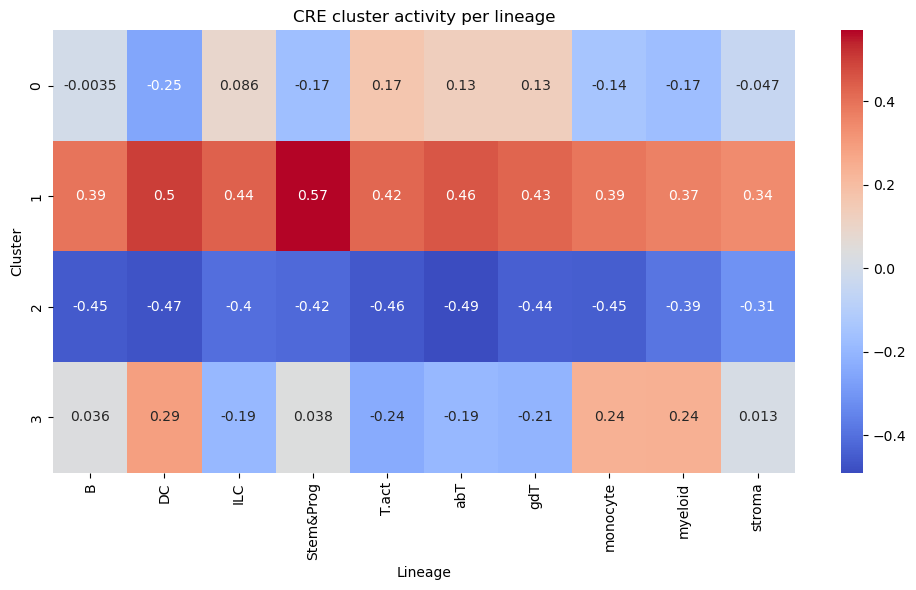

In [ ]:
# 1. Load QC matrix and create CellType → Lineage mapping
QC = pd.read_csv("data/ATAC_QCmatric.csv", sep=";")
QC.columns = QC.columns.str.strip()
QC["CellType"] = QC["CellType"].str.strip()
QC["Lineage"] = QC["Lineage"].str.strip()

celltype_to_lineage = QC.drop_duplicates("CellType").set_index("CellType")["Lineage"]

# 2. Extract ATAC signal data and cluster labels
signal_data = ATAC_scaled_ct.drop(columns="cluster")
clusters = ATAC_scaled_ct["cluster"]

# 3. Map each column (cell type) to its lineage
lineage_per_column = signal_data.columns.map(celltype_to_lineage)

# Optional: remove cell types not in QC (i.e., lineage = NaN)
valid_columns = ~lineage_per_column.isna()
signal_data = signal_data.loc[:, valid_columns]
lineage_per_column = lineage_per_column[valid_columns]

# Rename columns to lineage
signal_data.columns = lineage_per_column

# 4. Calculate mean signal per lineage
lineage_means = signal_data.groupby(signal_data.columns, axis=1).mean()

# 5. Add cluster labels back
lineage_means["cluster"] = clusters.values

# 6. Average signal per cluster across lineages
cluster_lineage_activity = lineage_means.groupby("cluster").mean()

# 7. Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_lineage_activity, cmap="coolwarm", annot=True)
plt.title("CRE cluster activity per lineage")
plt.xlabel("Lineage")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig("figures/CRE_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

Trying plots